# Supermarket Sales Exploratory Data Analysis in R

The following is an exploratory data analysis for a supermarket sales dataset from Kaggle ([Link to the dataset](https://www.kaggle.com/datasets/aungpyaeap/supermarket-sales)). This code showcases data cleaning, formatting and visualization techniques, as well as some statistical and econometrical analysis. The main question this code is concerned with, is to understand what variables (if any) affect the *total purchased amount* and the *quantity purchased* by customers in the dataset.

## Pre-Process

The first step in the process is to import the packages, and install them if they are not yet installed.

For ease of visibility, I suppress conflict warnings in order to not clutter the output. I turn warnings back off after importing to catch potential relevant warnings later in the process.

In [1]:
#Turn warnings off
options(warn=-1)
#Import
library(readr)
library(plyr)
library(dplyr,warn.conflicts=FALSE)
library(stringr)
library(reshape2)
library(ggplot2,warn.conflicts=FALSE) 
library(lubridate,warn.conflicts=FALSE)
library(stargazer,warn.conflicts=FALSE)
library(nnet)
#Turn them on
options(warn=0)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Please cite as: 

 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 



An important first step before processing the data is to specify the column types.

I purposely omit transforming certain columns such as gender into factors to showcase how to do that afterwards.

I am also using R's pre-determined data types (the suggested ones when importing the dataset) in order to show how to fix problematic columns later in the code.

In [2]:
colTypes <- cols(
  `Invoice ID` = col_character(),
  Branch = col_character(),
  City = col_character(),
  `Customer type` = col_character(),
  Gender = col_character(),
  `Product line` = col_character(),
  `Unit price` = col_double(),
  Quantity = col_double(),
  `Tax 5%` = col_double(),
  Total = col_double(),
  Date = col_character(),
  Time = col_time(format = ""),
  Payment = col_character(),
  cogs = col_double(),
  `gross margin percentage` = col_double(),
  `gross income` = col_double(),
  Rating = col_double()
)
#Import database
supermarket_sales <- read_csv("supermarket_sales.csv",col_types=colTypes)
#Take a look at the first details 
head(supermarket_sales)

Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00,Cash,76.40,4.761905,3.8200,9.6
631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23:00,Credit card,324.31,4.761905,16.2155,7.4
123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00,Ewallet,604.17,4.761905,30.2085,5.3
699-14-3026,C,Naypyitaw,Normal,Male,Electronic accessories,85.39,7,29.8865,627.6165,3/25/2019,18:30:00,Ewallet,597.73,4.761905,29.8865,4.1


Because the data is at the invoice level, it is important to check whether there is a repeated invoice ID in order to handle it.

Thankfully, the dataset does not have that issue.

In [3]:
#Verify there are no repeated ID's
length(unique(supermarket_sales$`Invoice ID`)) - length(supermarket_sales$`Invoice ID`)
#There is no difference so it's ok

[1] 0

Missing values are a huge source of headaches, before any analysis is done it is important to check how many of them are and how to deal with them.

Thankfully, as the cell below shows, there is no such problem in this dataset.

In [4]:
#Count the missing values across columns
apply(X = is.na(supermarket_sales), MARGIN = 2, FUN = sum)

Invoice ID                  Branch                    City 
                      0                       0                       0 
          Customer type                  Gender            Product line 
                      0                       0                       0 
             Unit price                Quantity                  Tax 5% 
                      0                       0                       0 
                  Total                    Date                    Time 
                      0                       0                       0 
                Payment                    cogs gross margin percentage 
                      0                       0                       0 
           gross income                  Rating 
                      0                       0

For ease of handling the data, columns that have a space in them are renamed. The convention I use is to replace a whitespace with an underscore.

The code handles a case where there is potentially more than one white space in the column name (such as in *gross margin percentage*) and replaces all of the existing whitespaces.

Additionally, one of the column names has a % sign on it. To keep only alphanumeric characters in the column names, I remove that percentage sign manually.

In [5]:
#Iterate over the column names and then replace whitespace for an underscore
column_names <- colnames(supermarket_sales)
#Iterate over column names
for (name in column_names){
    #Create string that replaces whitespace with underscore
    new_name <- sub(" ", "_", name)
    #Check if there is still whitespace\
    if (str_detect(new_name, " ")){
        new_name <- sub(" ", "_", new_name)
    }
    #Substitute in dataframe
    colnames(supermarket_sales)[which(names(supermarket_sales) == name)] <- new_name
}
#Let's see what the new column names look like
print(colnames(supermarket_sales))
#Everything lools good except that there is a percentage sign in the tax column
colnames(supermarket_sales)[9] <- "Tax_Five"

 [1] "Invoice_ID"              "Branch"                 
 [3] "City"                    "Customer_type"          
 [5] "Gender"                  "Product_line"           
 [7] "Unit_price"              "Quantity"               
 [9] "Tax_5%"                  "Total"                  
[11] "Date"                    "Time"                   
[13] "Payment"                 "cogs"                   
[15] "gross_margin_percentage" "gross_income"           
[17] "Rating"                 


A typical source of headaches when working with data are datetime variables. The code in the cell below formats the dates so they are considered a date object.

Because purchasing behaviour can vary seasonally, I take a look at the range of dates. The dataframe seems to span only three months.

In [6]:
#Data types that can be problematic are date and time
#First I want to take a look at what they look like
Date_Time <- c("Invoice_ID","Date","Time")
head(supermarket_sales[Date_Time])
#It looks understandable for humans, but having a date as a character can be tricky. I will begin formatting it
betterDates <- as.Date(supermarket_sales$Date,format = "%m/%d/%y")
#Change in dataframe
supermarket_sales$Date <- betterDates
#Check that the format is correct
class(supermarket_sales$Date)
#Want to understand minimum and max date to get the span of the dataset
range(supermarket_sales$Date)
#It seems the data is concentrated mostly around three months

Invoice_ID,Date,Time
750-67-8428,1/5/2019,13:08:00
226-31-3081,3/8/2019,10:29:00
631-41-3108,3/3/2019,13:23:00
123-19-1176,1/27/2019,20:33:00
373-73-7910,2/8/2019,10:37:00
699-14-3026,3/25/2019,18:30:00


[1] "Date"

[1] "2020-01-01" "2020-03-30"

One interesting feature of the dataset is that it spans (albeit briefly) two different seasons: winter and spring.

I create a season variable to check whether there are variations in the purchasing behaviour between both seasons.

Note: Because of the narrowness of the range of the dates in the dataset, I do not expect to see a major shift in behaviour. I do consider this analysis valuable because it can be re-used if in the future more data becomes available.

In [7]:
#Something that can be beneficial is understanding purchasing habits by the season
#I can create a function that checks whether the date is greater than the spring equinox or not
#If it is not, then it is winter, if it is then it is spring
#I do this in a simple fashion because of the narrow range of dates
getSeason <- function(DATES) {
    SE <- as.Date("2012-3-15",  format = "%Y-%m-%d") # Spring Equinox
    # Convert dates from any year to 2012 dates
    #This is because it is a leap year and this can be generalized further
    d <- as.Date(strftime(DATES, format="2012-%m-%d"))
    
    ifelse(d < SE,"Winter","Spring")
}
seasons_vector <- getSeason(supermarket_sales$Date)
supermarket_sales$season <- seasons_vector

Another date-related variable that can affect purchasing behaviour is the weekday.

For each entry, I assign the corresponding weekday associated with it.

I first get dates as a POSIXt object and then access a vector with weekdays for easy access.

The reason why I did it in such a relatively roundabout way is because this solution works independently of the language of the computer's operative system. Other more common solutions change the names of the weekdays to the corresponding word in the corresponding operative system's language (such as changing *Sunday* to *Domingo* in a computer in Spanish).

In [8]:
supermarket_sales$weekday <- c("Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", 
    "Friday", "Saturday")[as.POSIXlt(supermarket_sales$Date)$wday + 1]

The time of day can also be relevant in driving consumer behaviour. While I do not think that one minute can make a difference in purchasing behaviour, I do think that it is feasible to consider that the time of day (morning, afternoon, etc...) can make a difference in what is bought and its quantity.

In [9]:
# Create breaks
breaks <- hour(hm("00:00", "6:00", "12:00", "18:00", "23:59"))
# Labels for the breaks
labels <- c("Night", "Morning", "Afternoon", "Evening")
# Join
supermarket_sales$TimeOfDay <- cut(x=hour(supermarket_sales$Time), breaks = breaks, labels = labels, include.lowest=TRUE)

The final pre-processing step is to format certain variables.

*Branch*, *city*, gender, *product line* and *payment* can be interpreted as nominal categorical variables (there is no order), whereas *season* and *weekdays* can be interpreted as ordinal categorical variables (there is some order).

In [10]:
#Define categories
ordinal_categories <- c("Branch","City","Customer_type","Gender","Product_line","Payment")
#Apply categorical
supermarket_sales[,ordinal_categories] <- lapply(supermarket_sales[,ordinal_categories] , factor)
supermarket_sales$season <- factor(supermarket_sales$season, order = TRUE, 
                                   levels =c('Winter', 'Spring'))
#For days, just the order of the weekday
supermarket_sales$weekday <- factor(supermarket_sales$weekday, order = TRUE, 
                                   levels =c('Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                            'Friday','Saturday','Sunday'))

## Descriptives and Initial Analysis

After those preliminaries, it is time to dive into the data!

For numerical variables, I am interested in learning how they distribute. For categorical, I am more interested in trends.

I begin by using summary to identify patterns in data.

I do numerical and categorical descriptives separately for readibility purposes.

In [11]:
#After those preliminaries, its time to dive into the data!
#For numerical variables, I am interested in learning how they distribute
#For categorical, I am more interested in trends
#I begin using summary to identify patterns in data
#Do numerical and categorical separately for readibility purposes
numerical_columns <- c('Unit_price','Quantity','Tax_Five','Total','cogs','gross_margin_percentage','gross_income','Rating')
factor_columns <- append(ordinal_categories,c('season','weekday'))
print('Numerical')
summary(supermarket_sales[numerical_columns])
print('Categorical')
summary(supermarket_sales[factor_columns])

[1] "Numerical"


   Unit_price       Quantity        Tax_Five           Total        
 Min.   :10.08   Min.   : 1.00   Min.   : 0.5085   Min.   :  10.68  
 1st Qu.:32.88   1st Qu.: 3.00   1st Qu.: 5.9249   1st Qu.: 124.42  
 Median :55.23   Median : 5.00   Median :12.0880   Median : 253.85  
 Mean   :55.67   Mean   : 5.51   Mean   :15.3794   Mean   : 322.97  
 3rd Qu.:77.94   3rd Qu.: 8.00   3rd Qu.:22.4453   3rd Qu.: 471.35  
 Max.   :99.96   Max.   :10.00   Max.   :49.6500   Max.   :1042.65  
      cogs        gross_margin_percentage  gross_income         Rating      
 Min.   : 10.17   Min.   :4.762           Min.   : 0.5085   Min.   : 4.000  
 1st Qu.:118.50   1st Qu.:4.762           1st Qu.: 5.9249   1st Qu.: 5.500  
 Median :241.76   Median :4.762           Median :12.0880   Median : 7.000  
 Mean   :307.59   Mean   :4.762           Mean   :15.3794   Mean   : 6.973  
 3rd Qu.:448.90   3rd Qu.:4.762           3rd Qu.:22.4453   3rd Qu.: 8.500  
 Max.   :993.00   Max.   :4.762           Max.   :49.65

[1] "Categorical"


 Branch         City     Customer_type    Gender   
 A:340   Mandalay :332   Member:501    Female:501  
 B:332   Naypyitaw:328   Normal:499    Male  :499  
 C:328   Yangon   :340                             
                                                   
                                                   
                                                   
                                                   
                 Product_line        Payment       season         weekday   
 Electronic accessories:170   Cash       :344   Winter:836   Monday   :155  
 Fashion accessories   :178   Credit card:311   Spring:164   Tuesday  :129  
 Food and beverages    :174   Ewallet    :345                Wednesday:139  
 Health and beauty     :152                                  Thursday :155  
 Home and lifestyle    :160                                  Friday   :141  
 Sports and travel     :166                                  Saturday :131  
                                             

The summary statistics help as a first approach to understand distribution of the data. 

It seems that *gender*, *city* and *Customer_type* are balanced. The variable *gross_margin_percentage* does not change, so it can be ignored for the analysis.

Another way to represent the data is through visualization. This is because it provides certain information in a more digestable and fast way. My first approach is to graphically represent the number of observation for the factor variables.

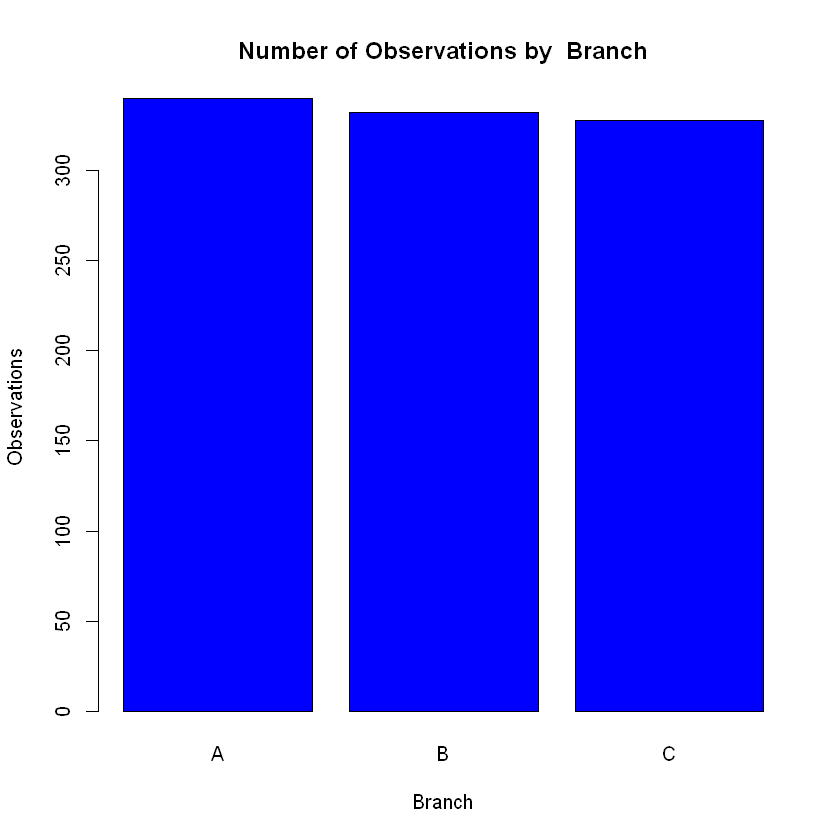

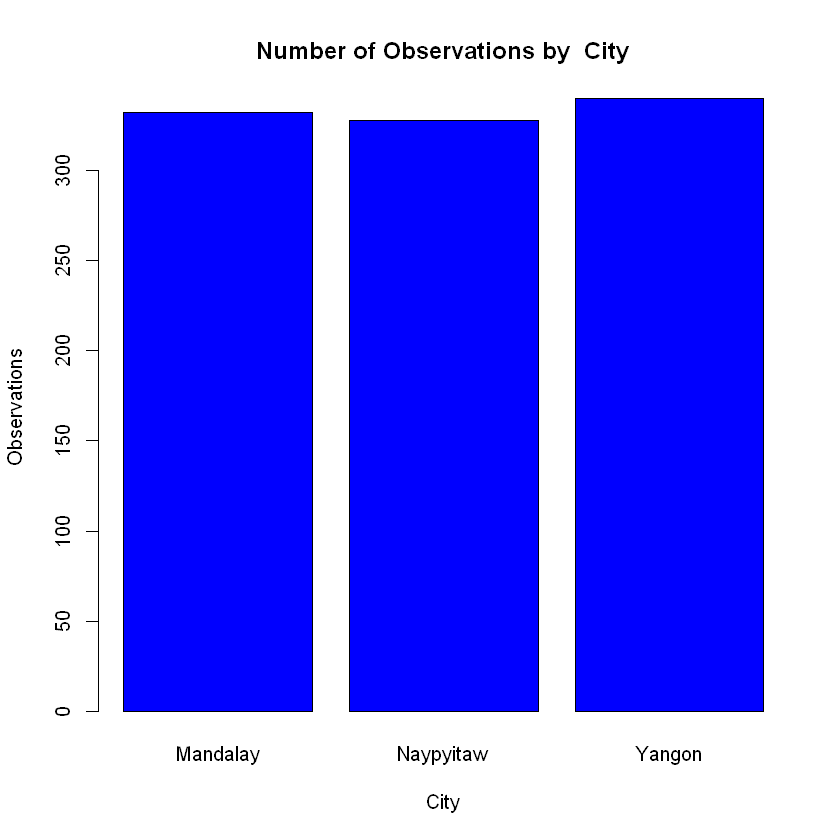

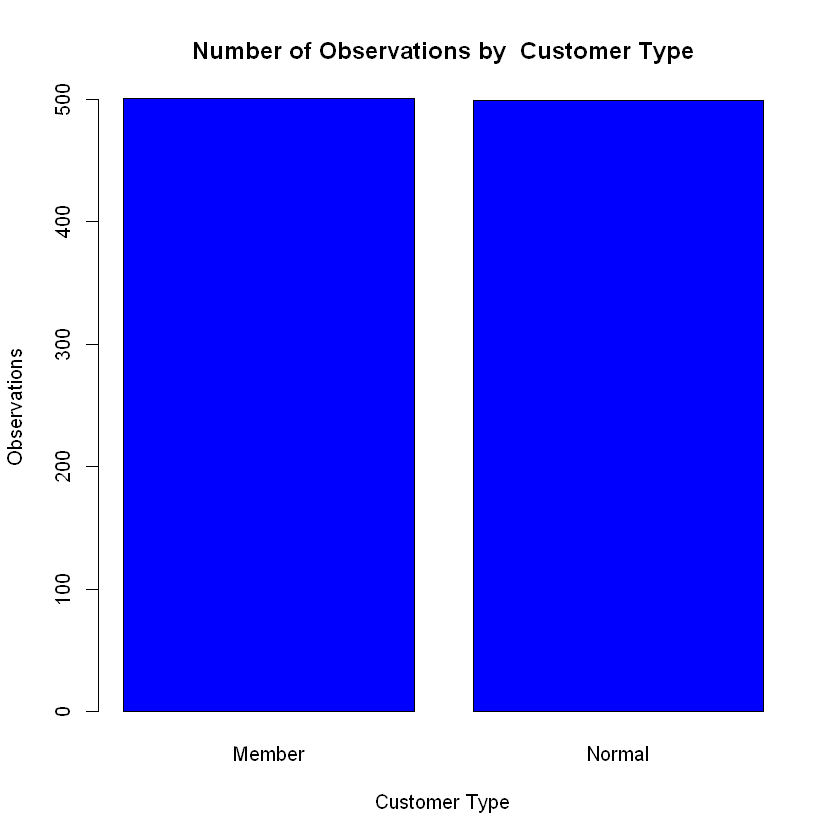

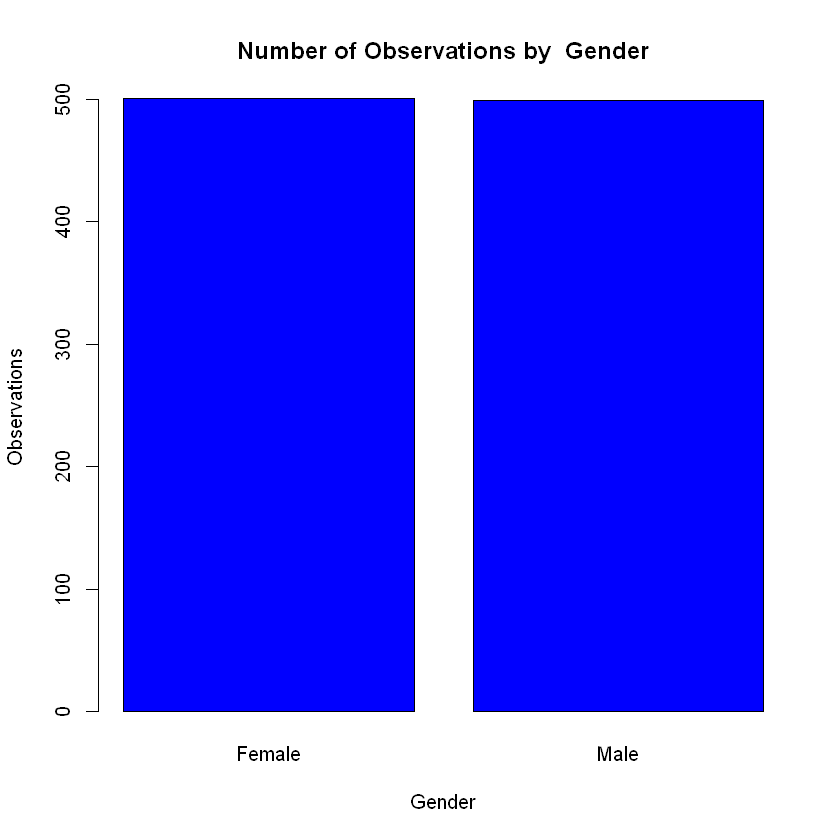

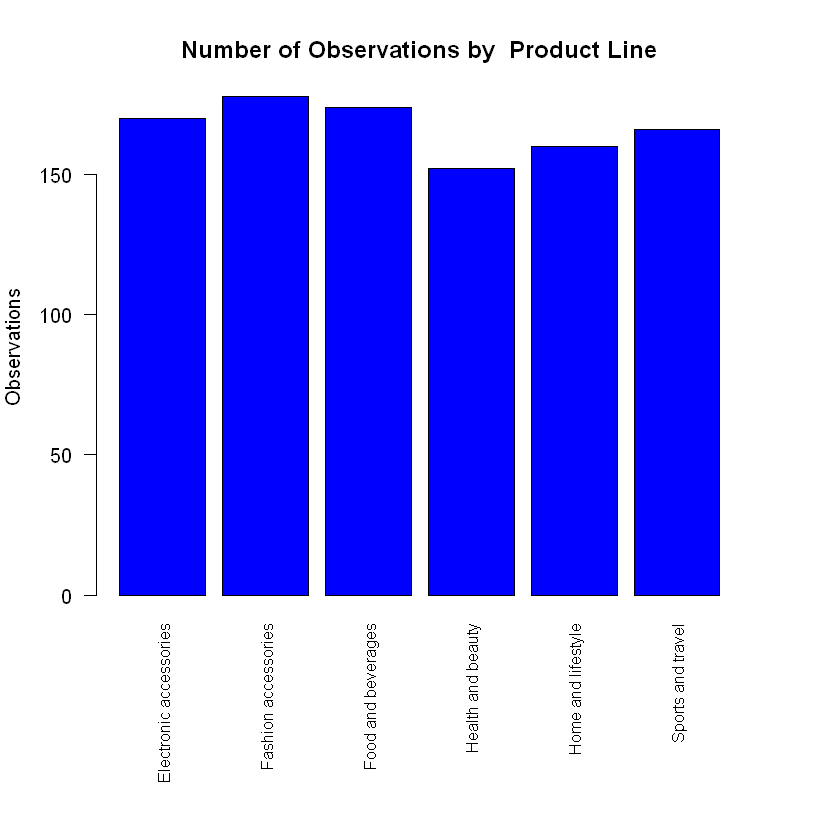

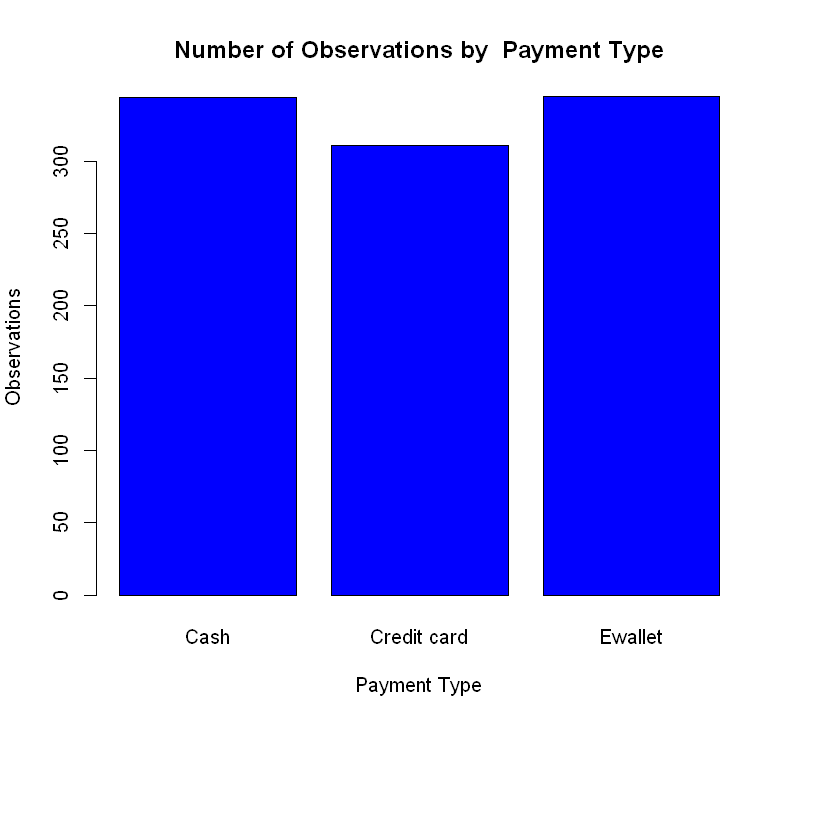

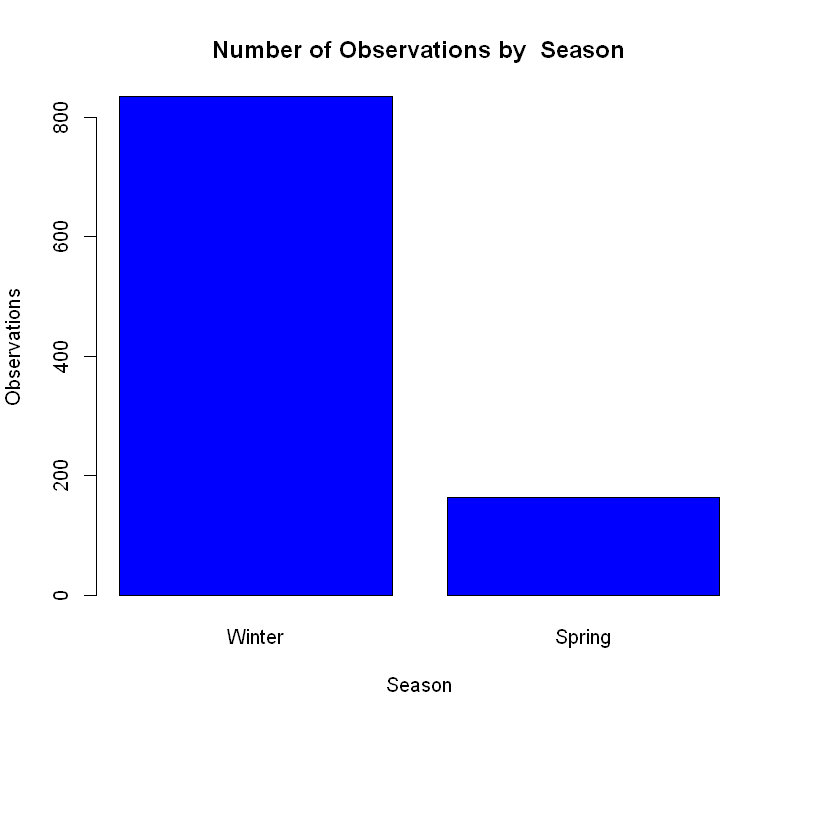

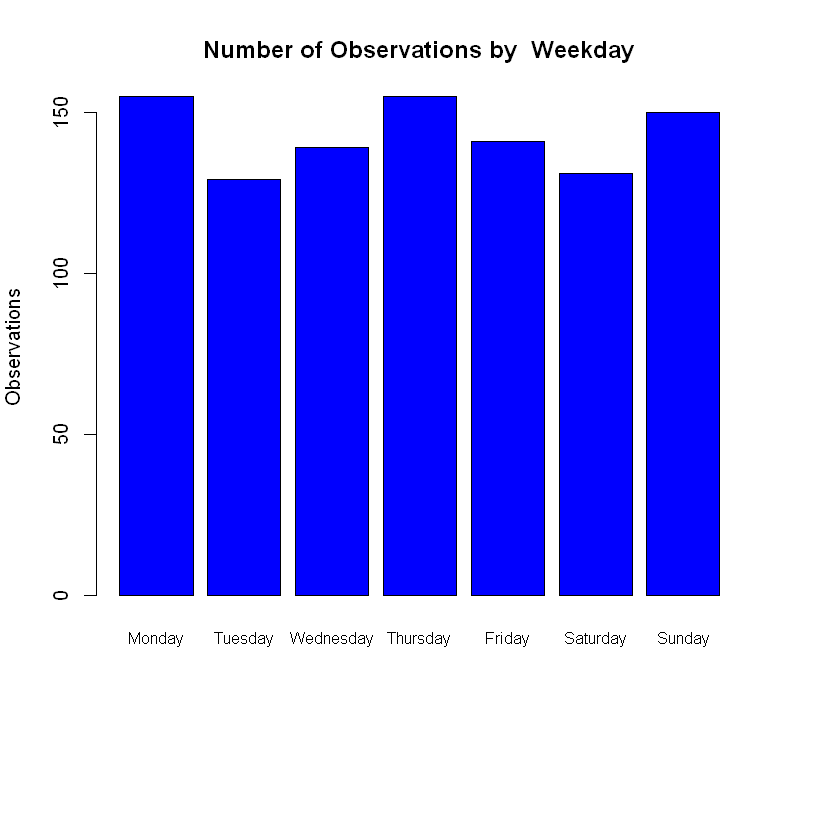

In [12]:
#To make the plots prettier, I create a dictionary where I can convert from the name in the dataframe to a name that is
#more visually appealing for readers. That is, replacing the underscore with white space
x_dict <- c('Customer_type'='Customer Type','City'='City','Gender'='Gender','weekday'='Weekday','season'='Season',
           'Branch'='Branch','Payment'='Payment Type','Product_line'='Product Line')
#First, define the variables to visualize
for (var in factor_columns){
    #Get a frequency table for the variable
    freqTable <- table(supermarket_sales[[var]])
    #Retrieve the pretty name
    varname = x_dict[var]
    #Get title
    title_val = paste("Number of Observations by ",varname)
    #Represent with a barplot
    #Because the names in the weekday and product line categories are too big for the standard barplot
    #I customize the bar widths just for those
    if (var == 'Product_line'){
      par(mar=c(10,4,4,4))
        barplot(height=freqTable,xlab="",ylab="Observations",main=title_val,col="blue",las=2,cex.names=.8) +
      geom_boxplot(fill = "#0099f8") + theme_classic()  
    }else if (var == 'weekday'){
      par(mar=c(10,4,4,4))
        barplot(height=freqTable,xlab="",ylab="Observations",main=title_val,col="blue",cex.names=.8) +
      geom_boxplot(fill = "#0099f8") + theme_classic()  
    }else{
      barplot(height=freqTable,xlab=varname,ylab="Observations",main=title_val,col="blue") +
      geom_boxplot(fill = "#0099f8") + theme_classic()  
    }

} 
#Represent with barplot

I continue my visualization task by understanding how certain variables change as a function of others. This can help identify certain patterns on the data. For example, are there differences in the purchase habits by customer type? I dive into that question by analyzing the differences in total amount, quantity and rating.

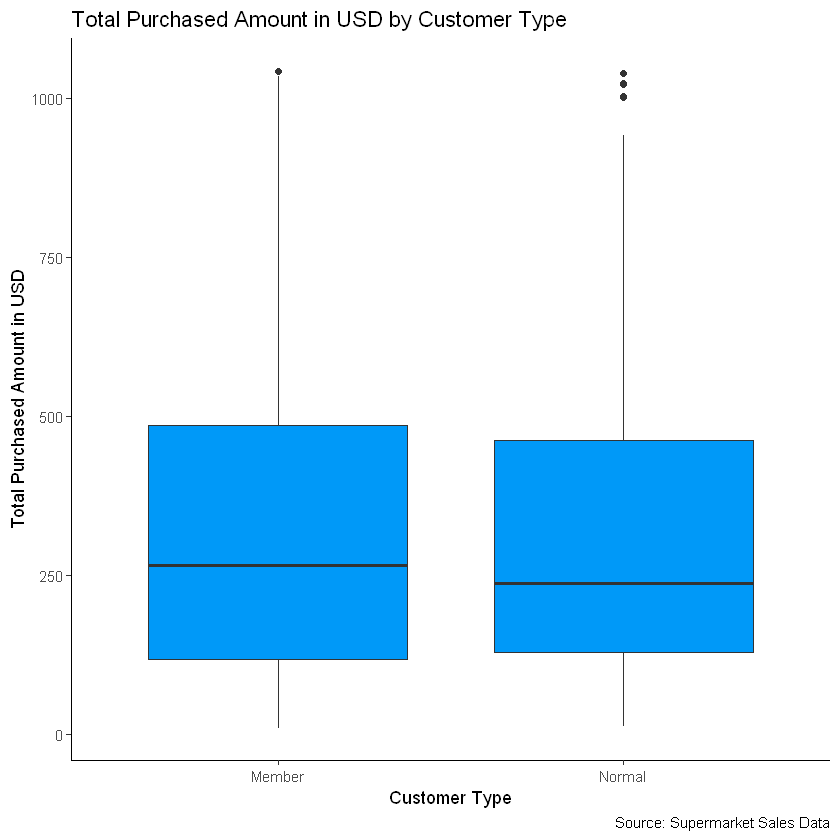

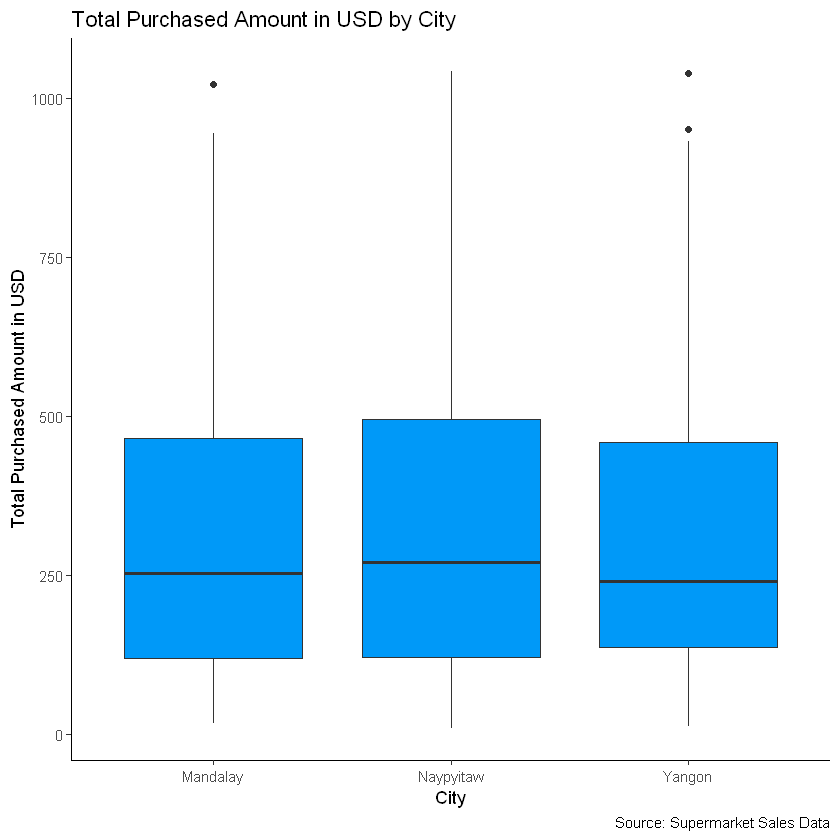

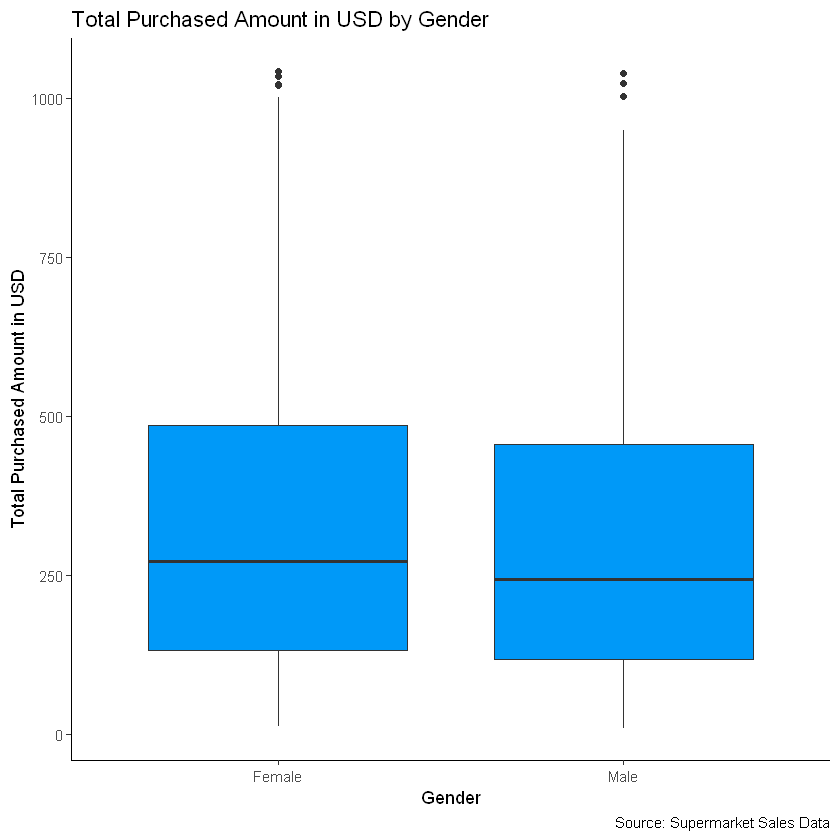

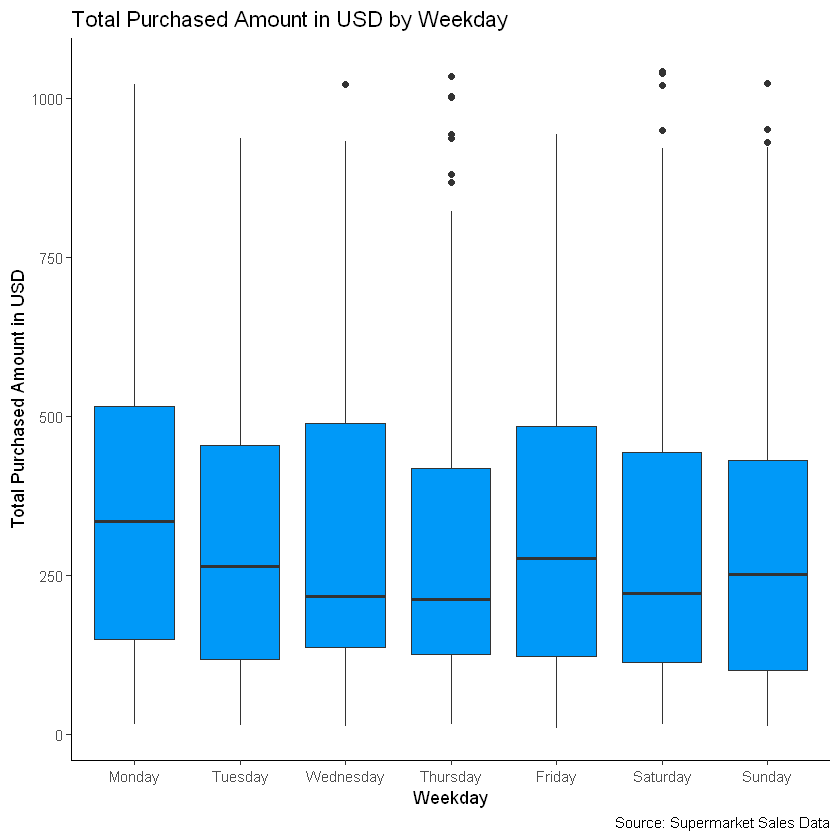

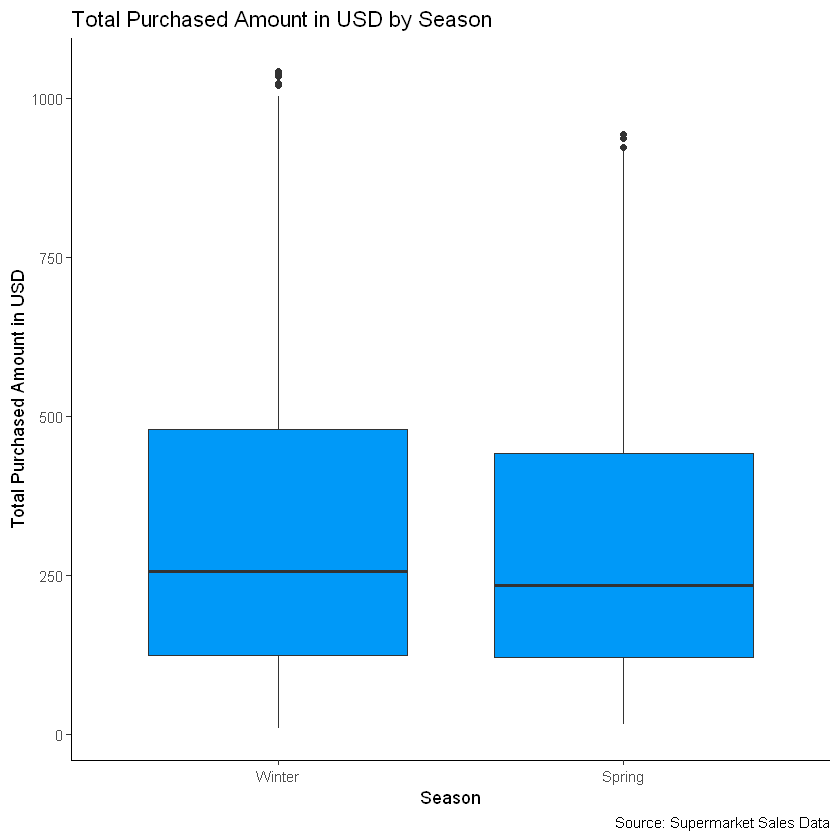

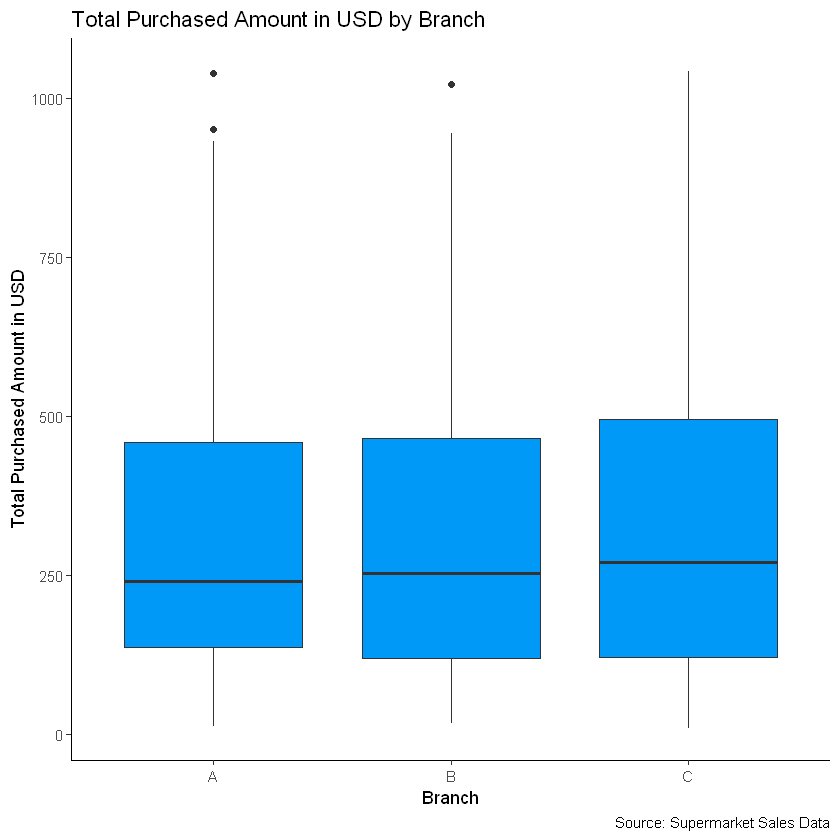

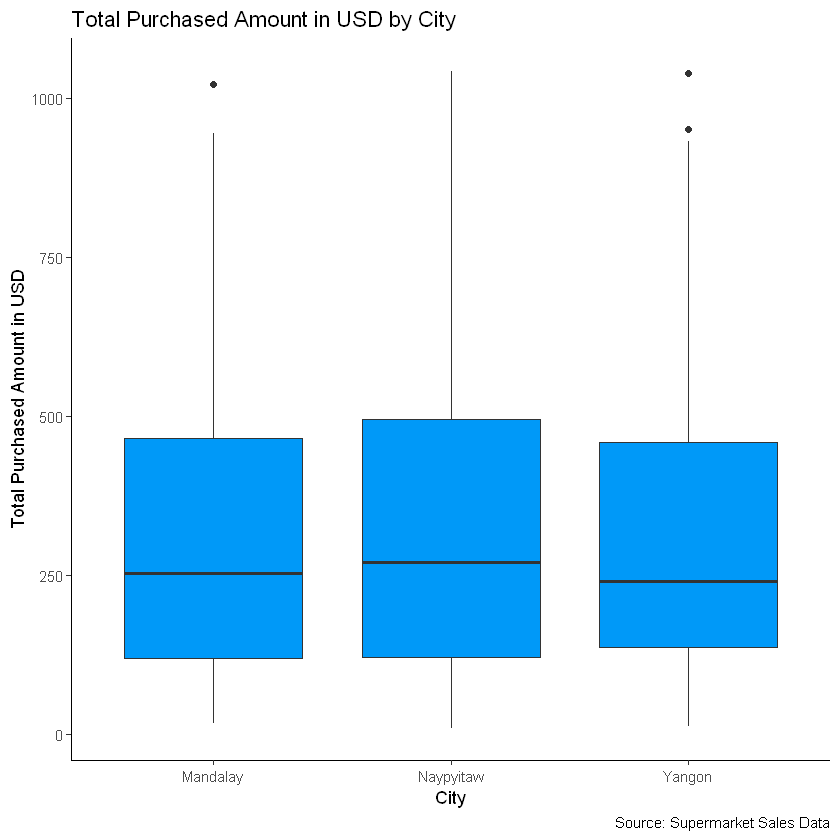

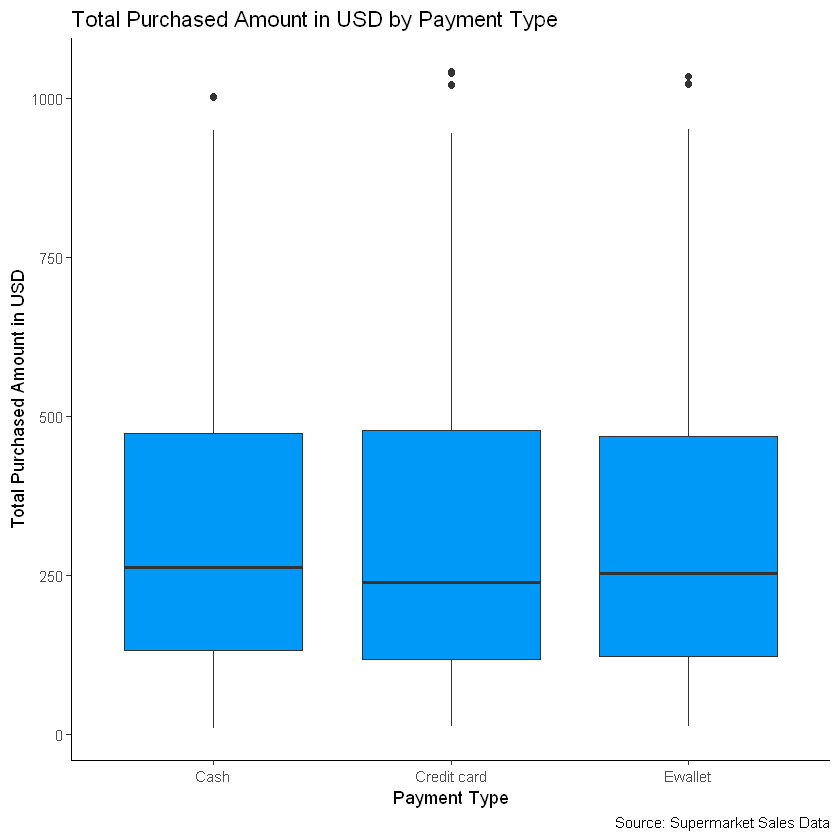

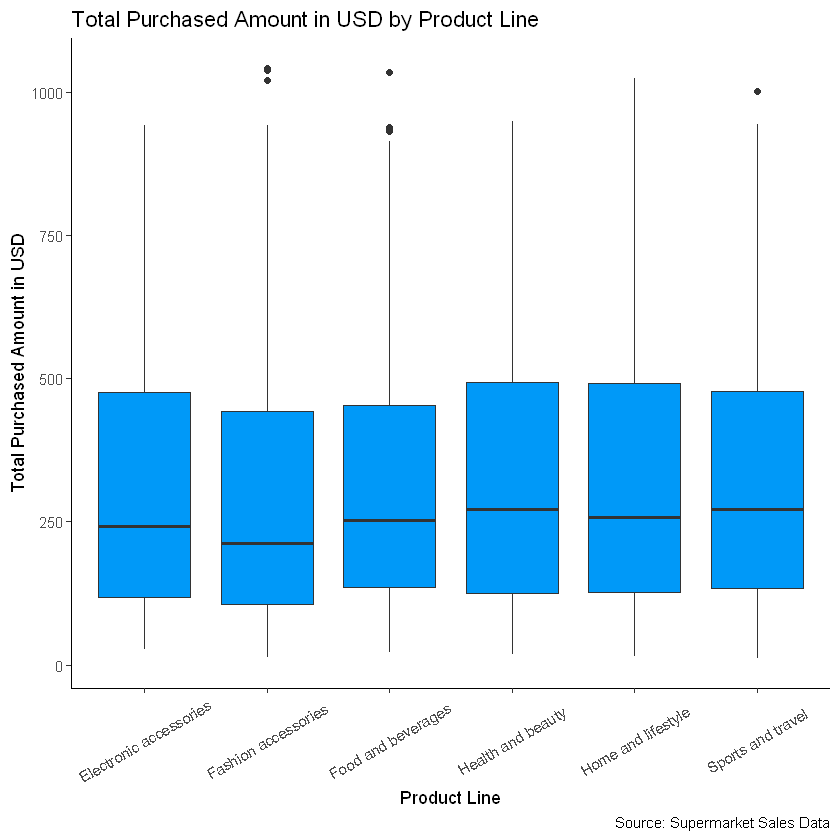

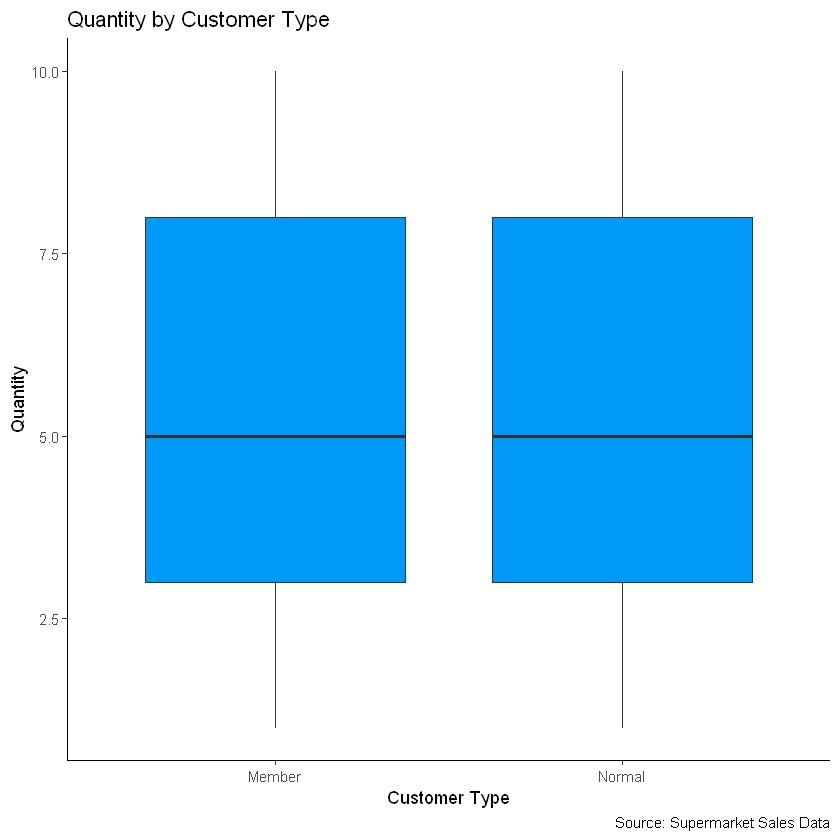

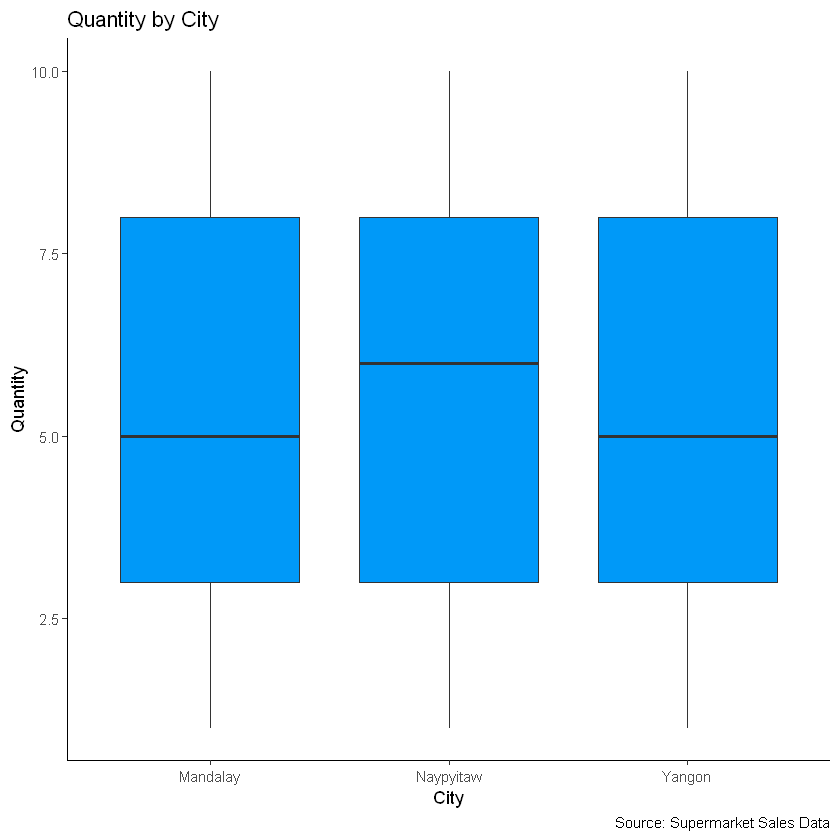

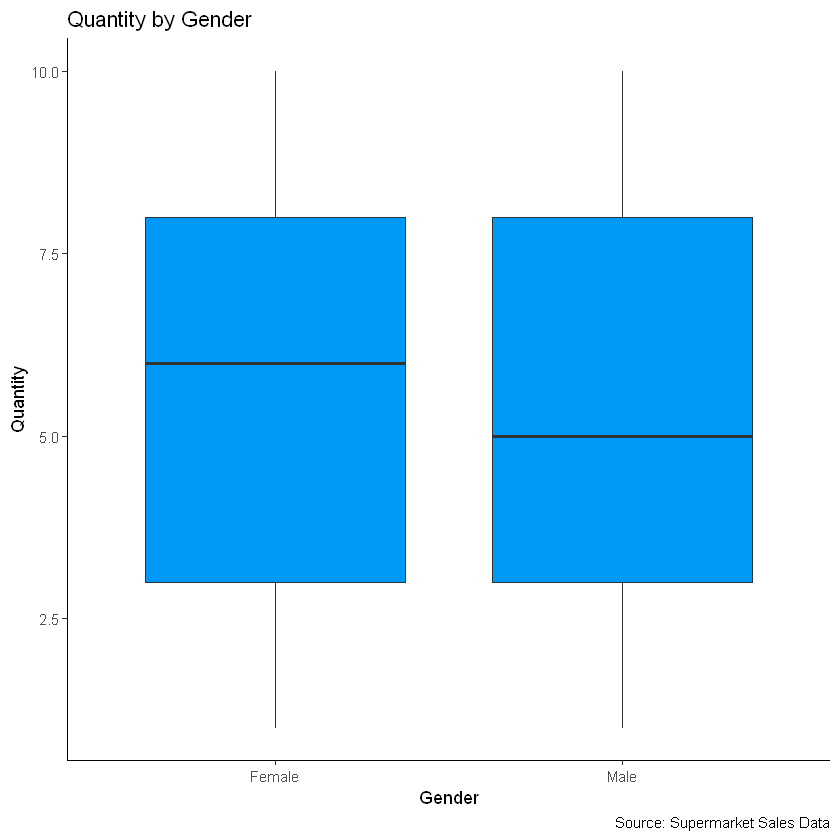

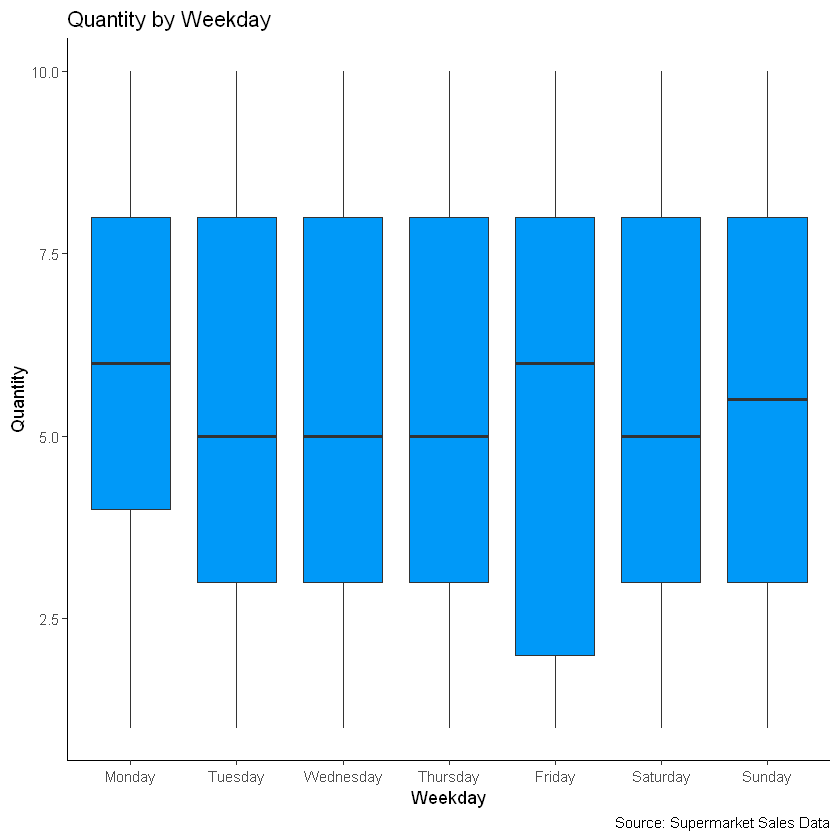

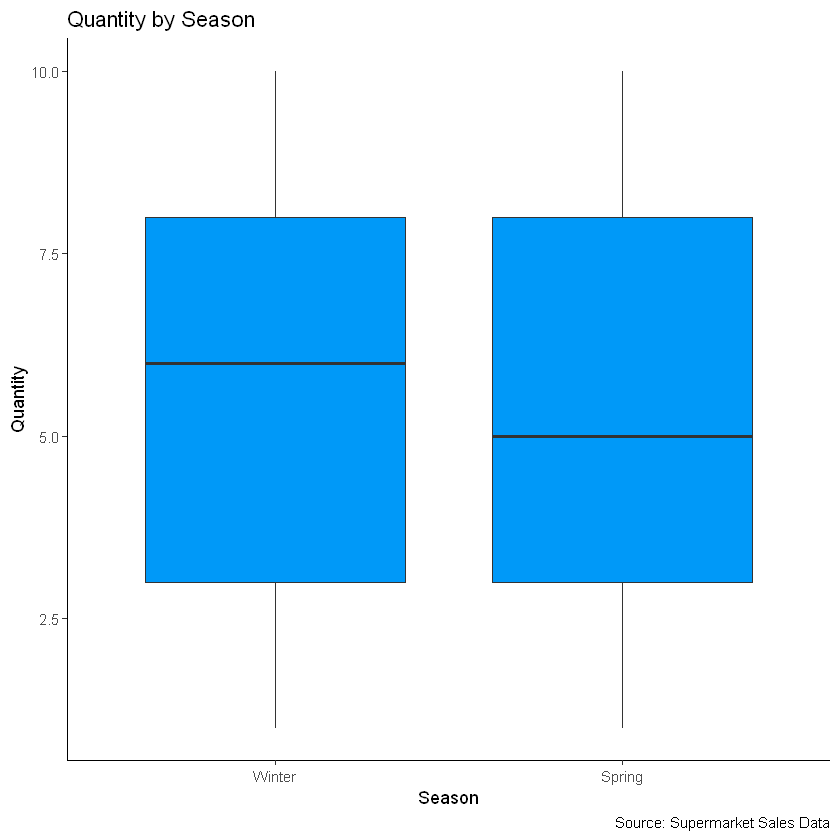

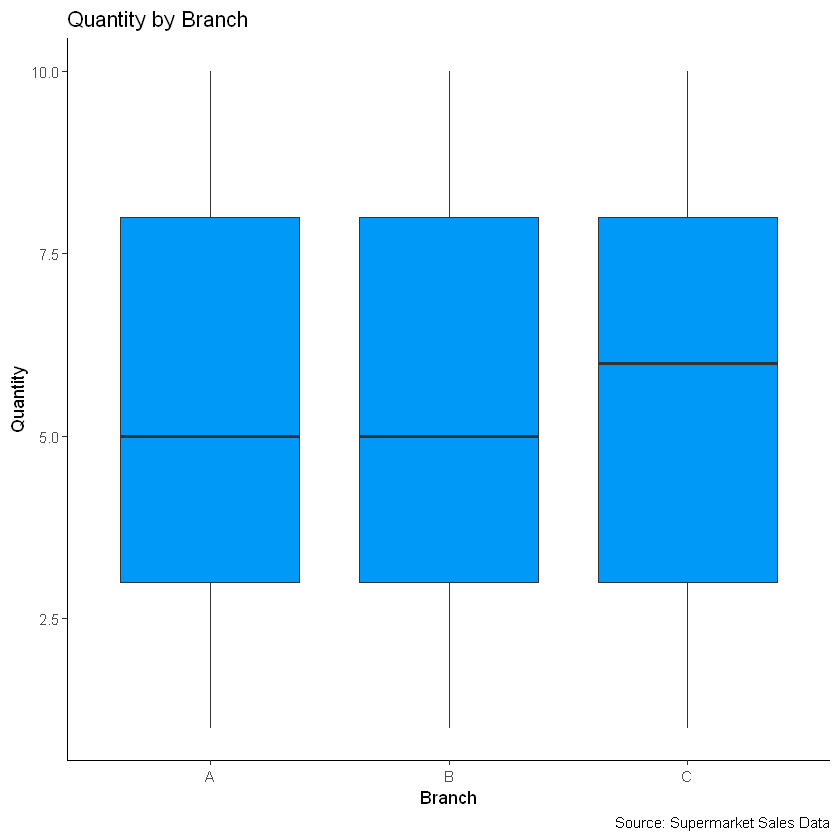

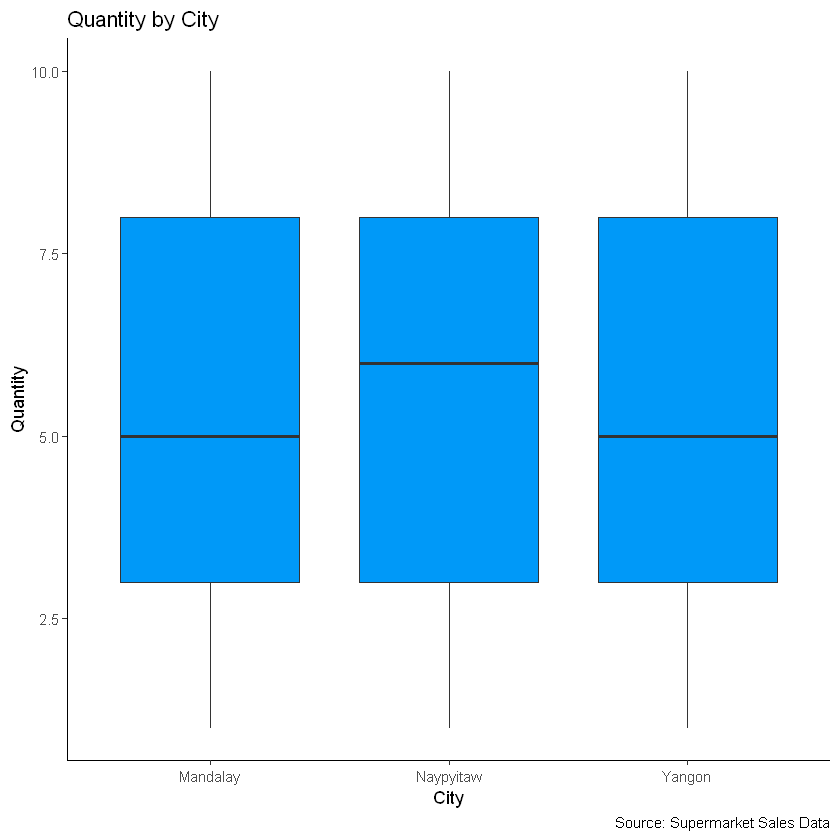

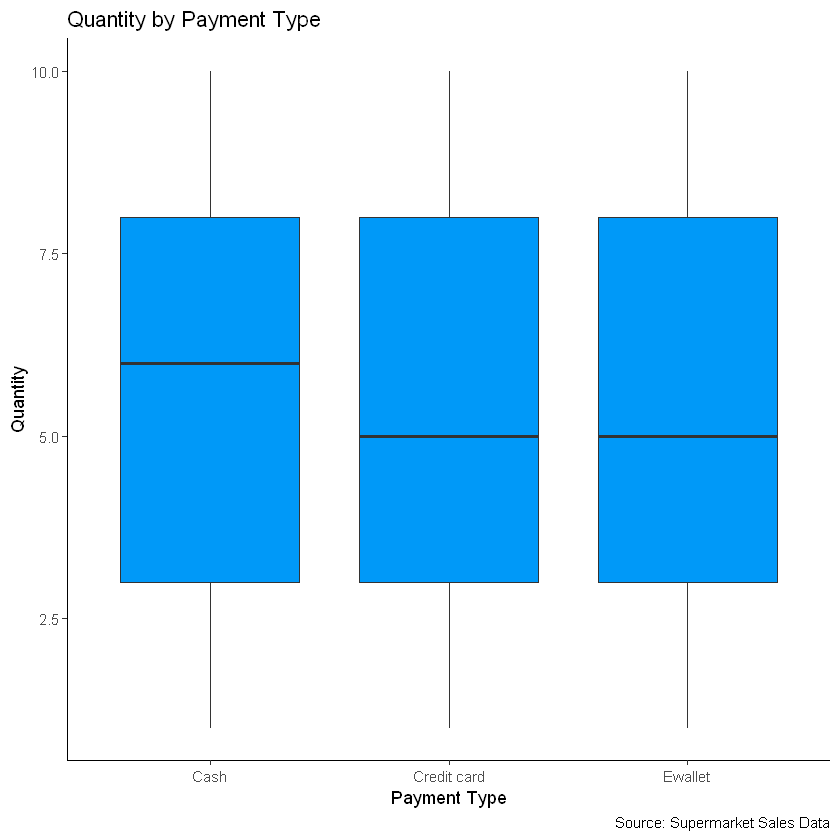

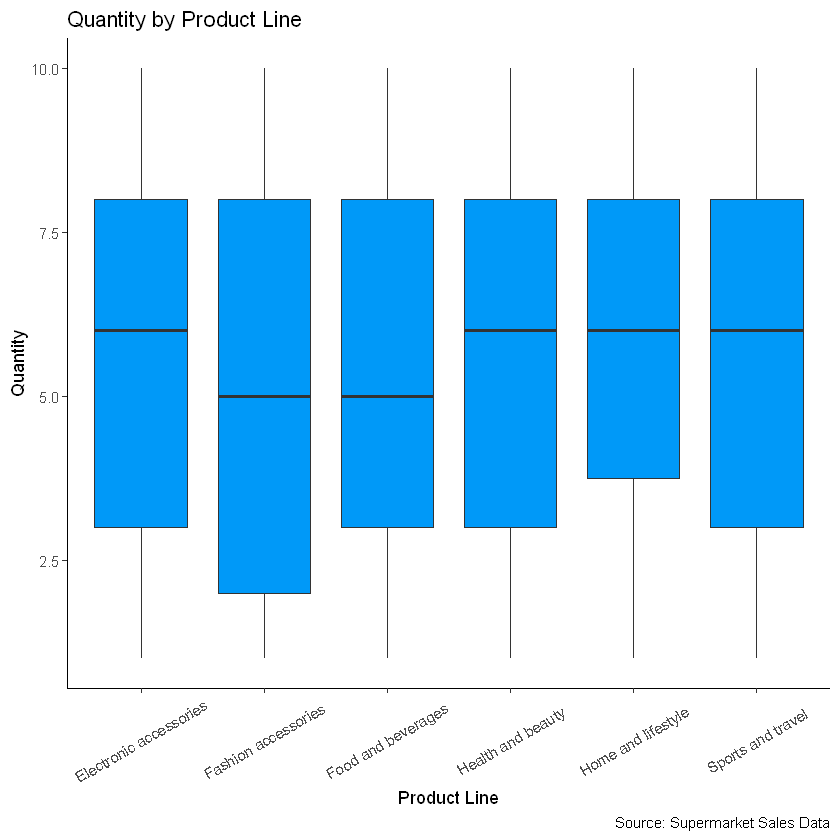

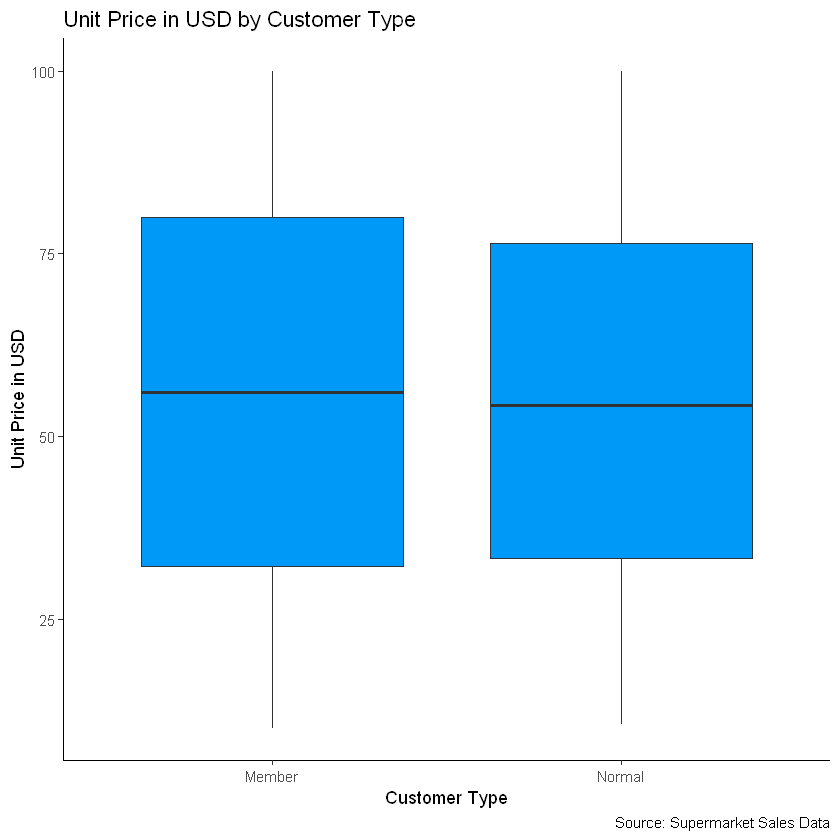

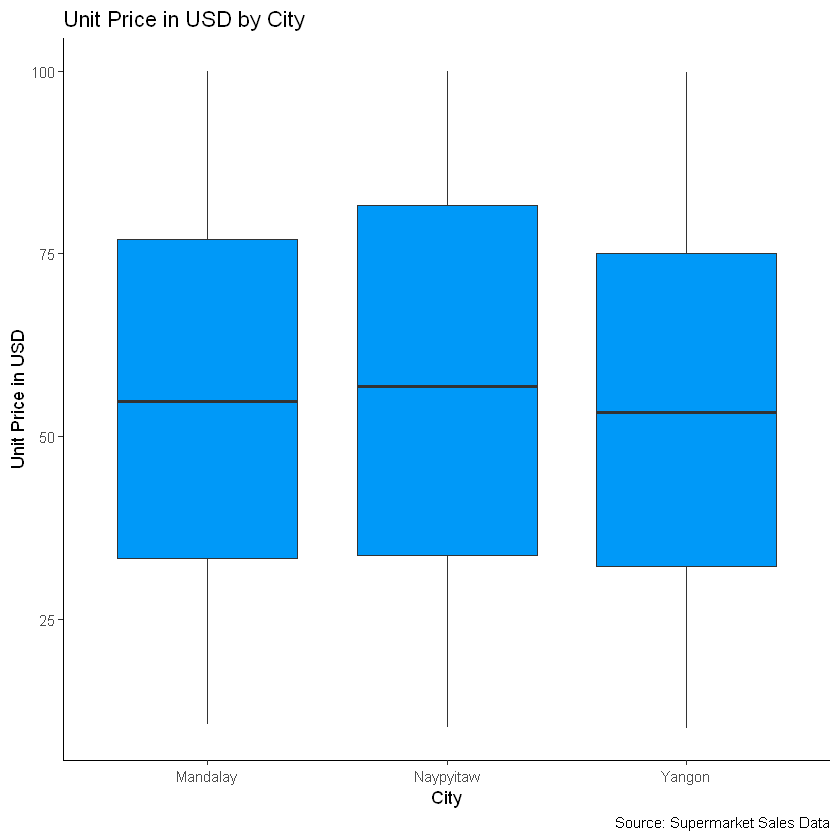

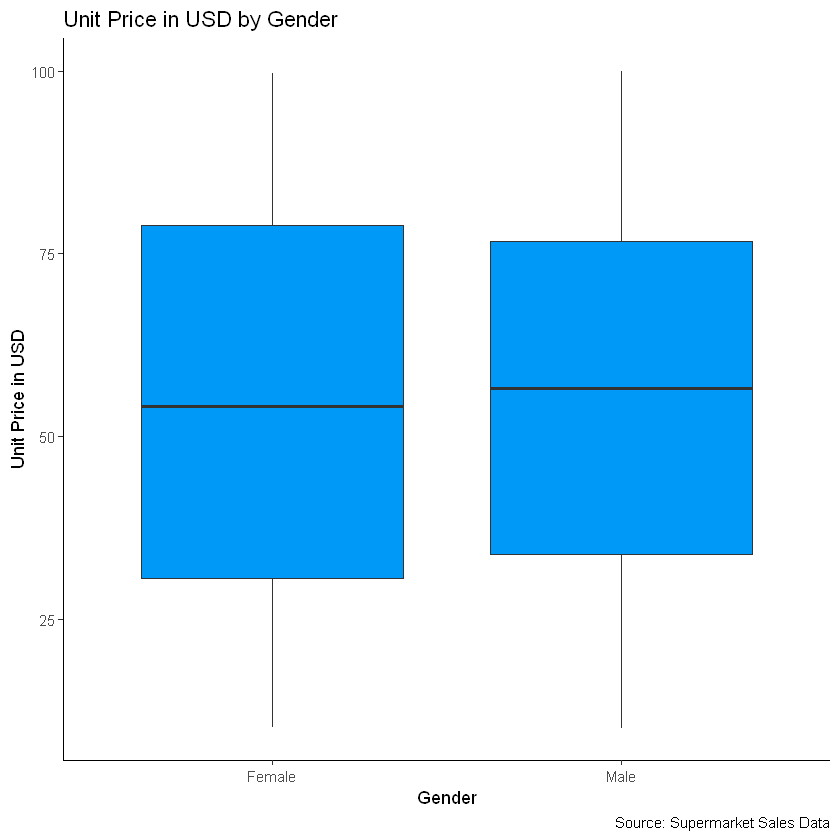

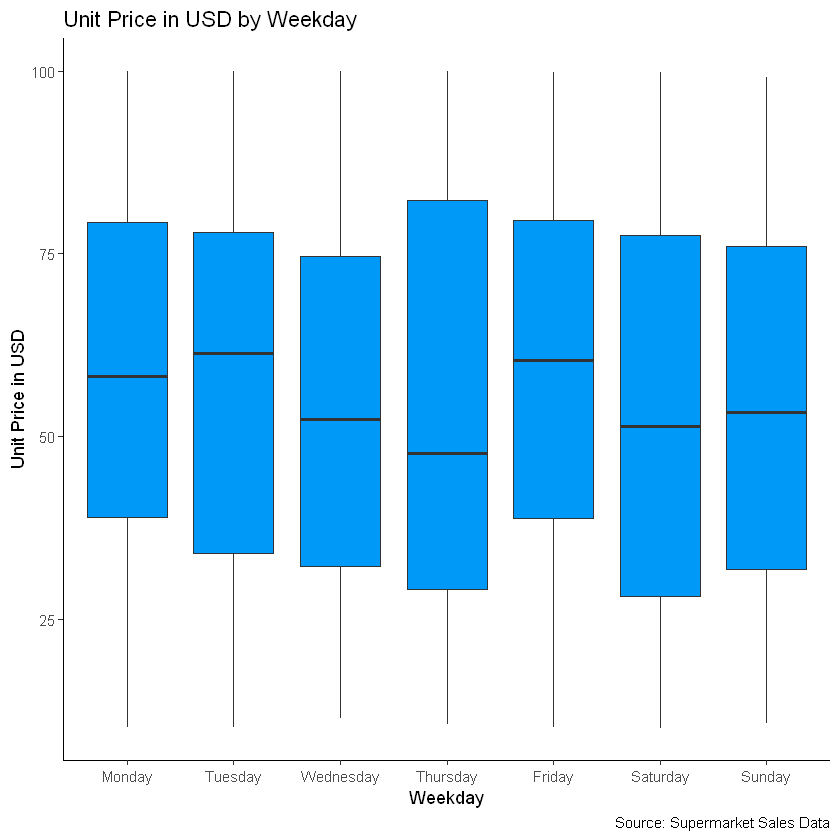

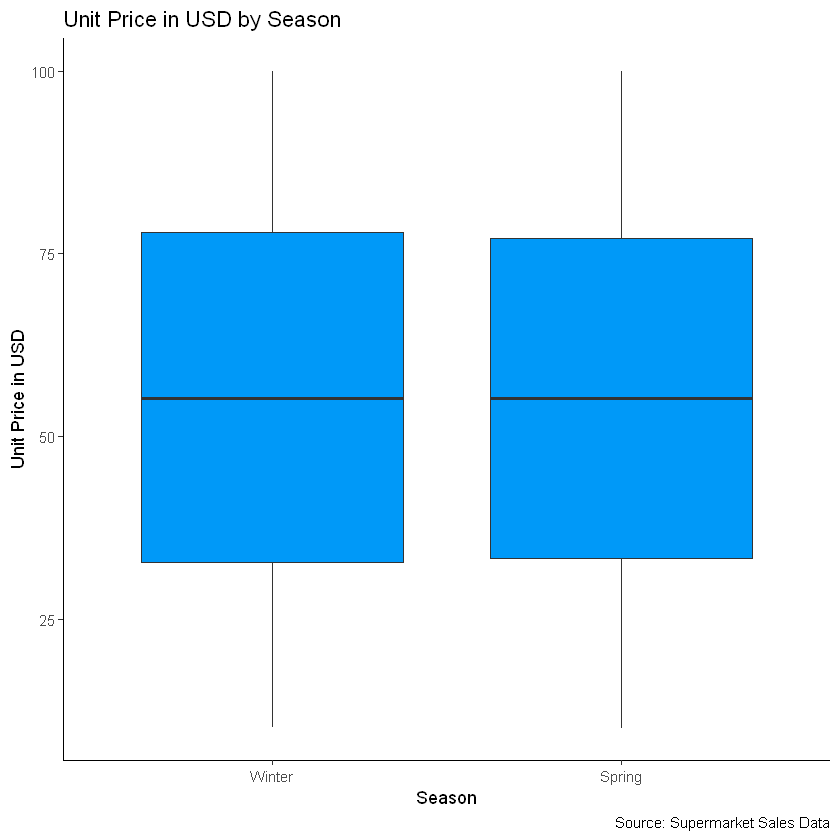

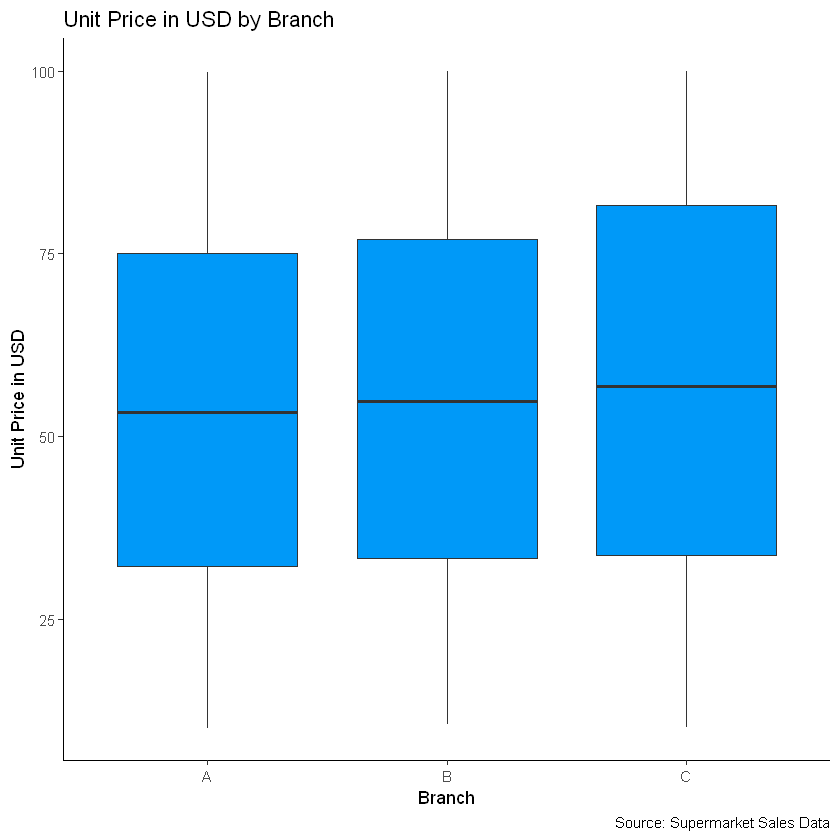

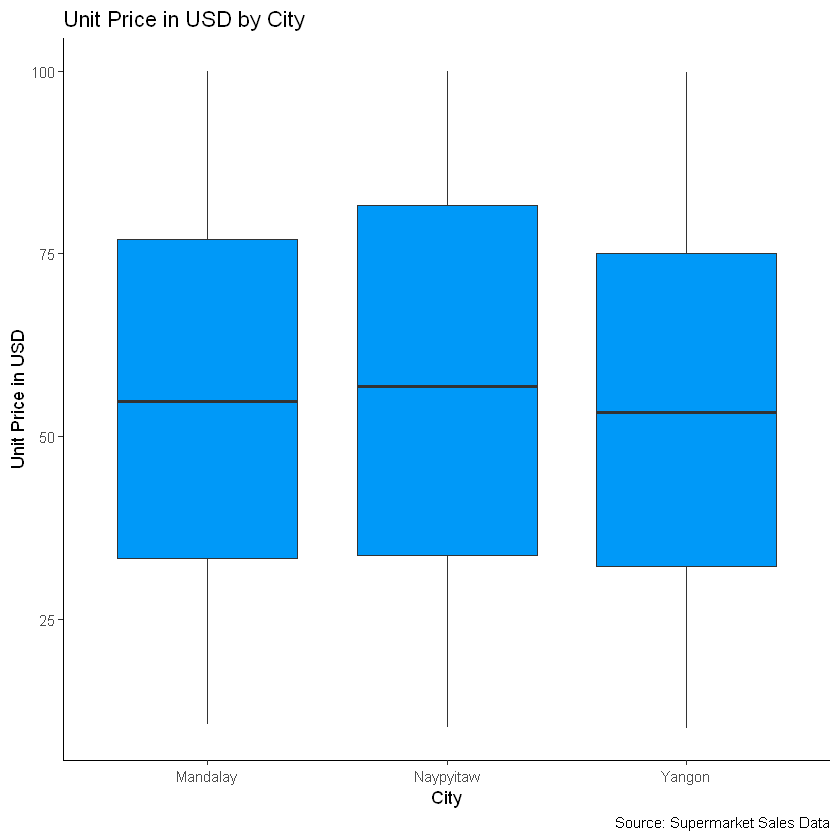

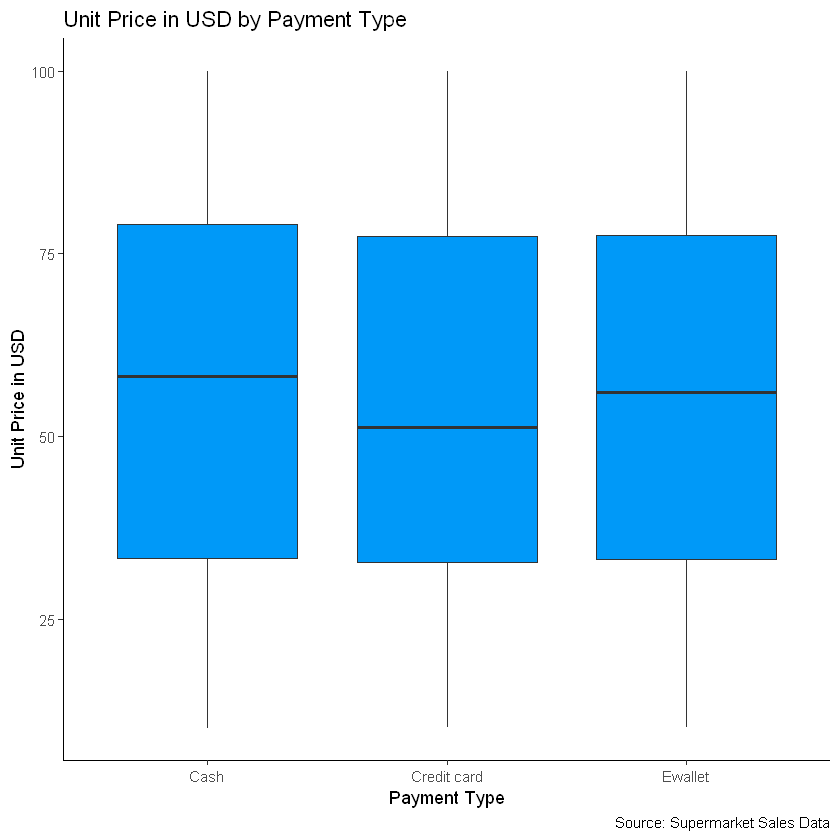

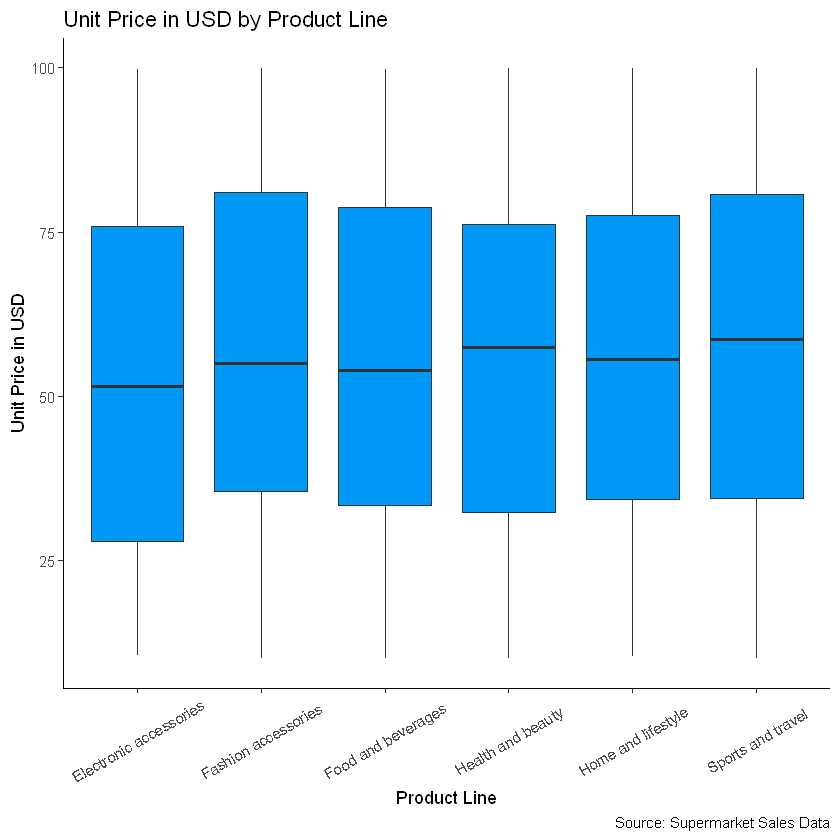

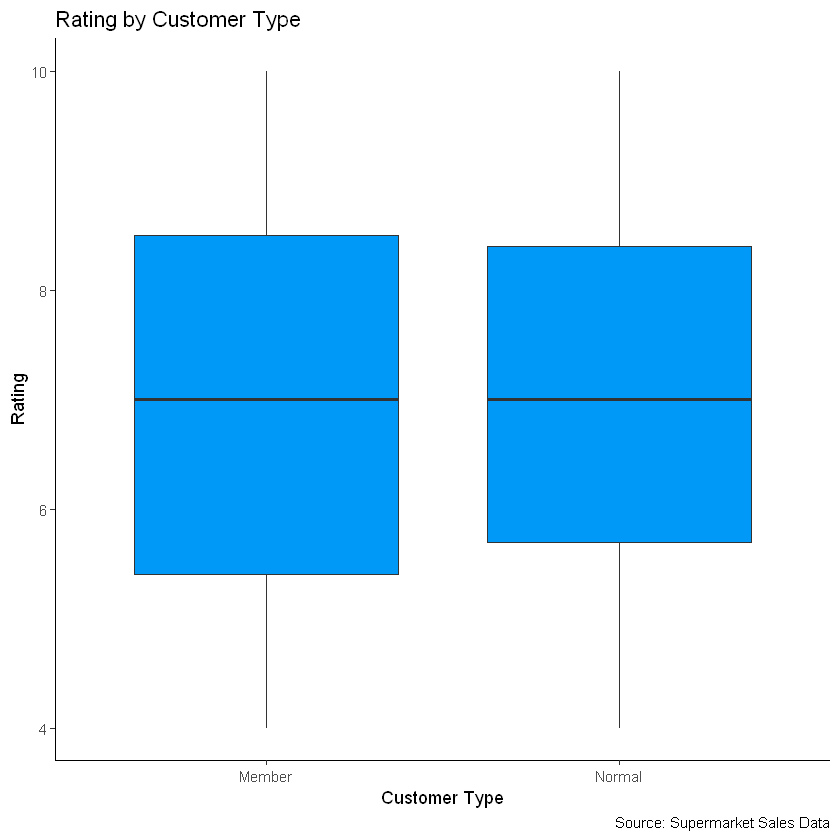

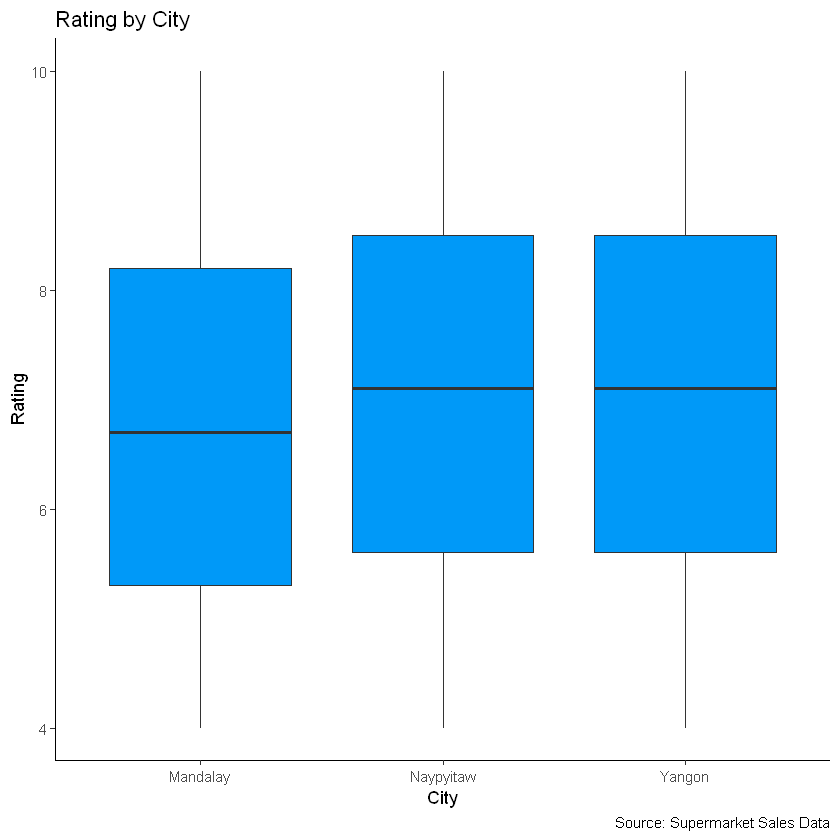

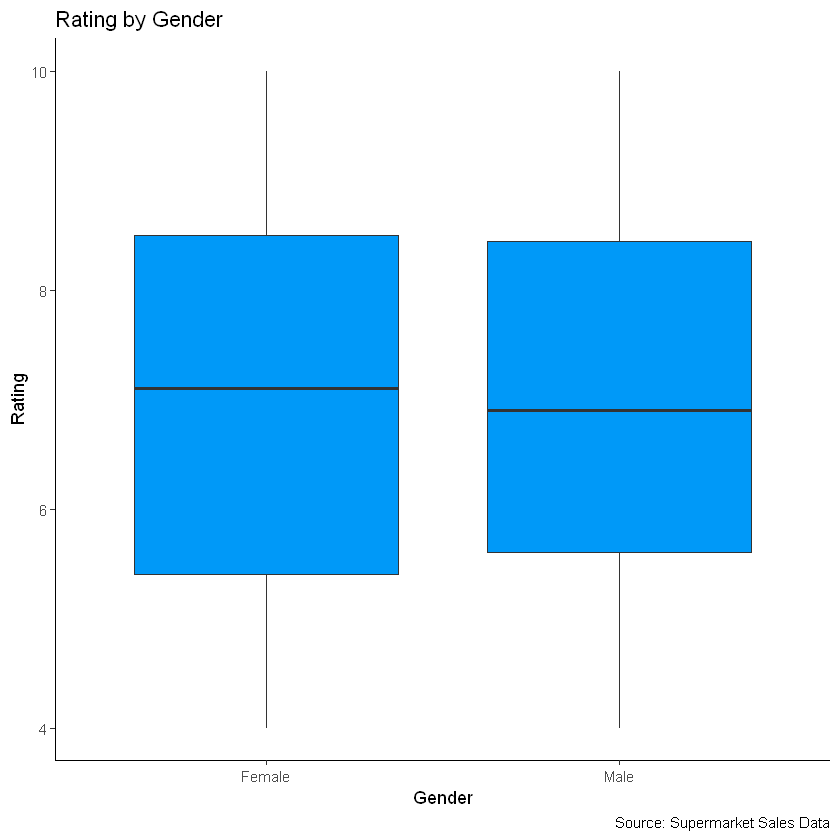

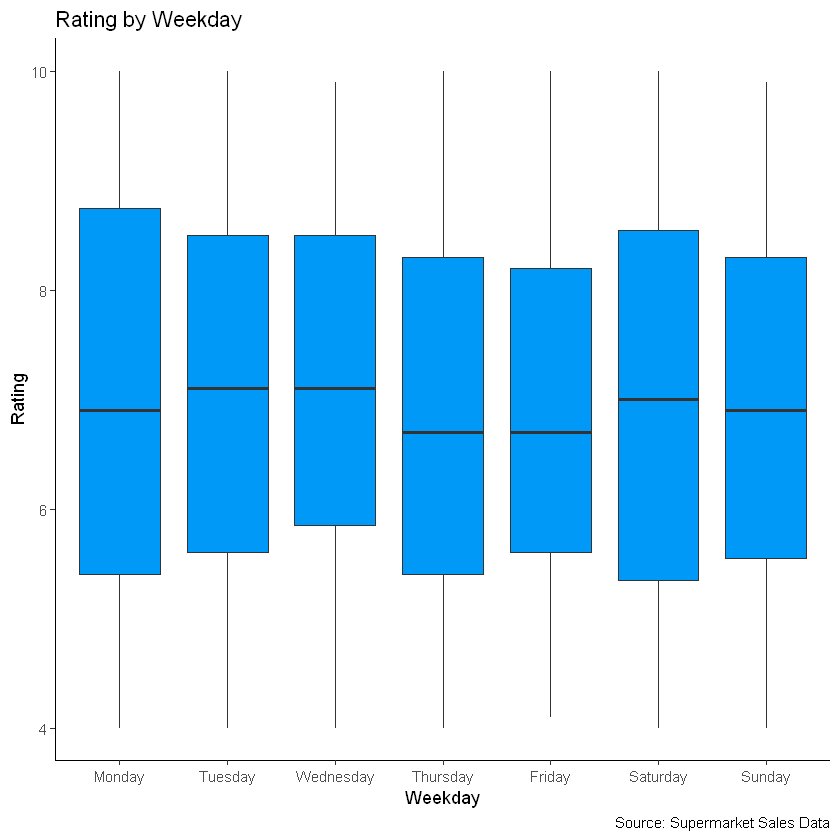

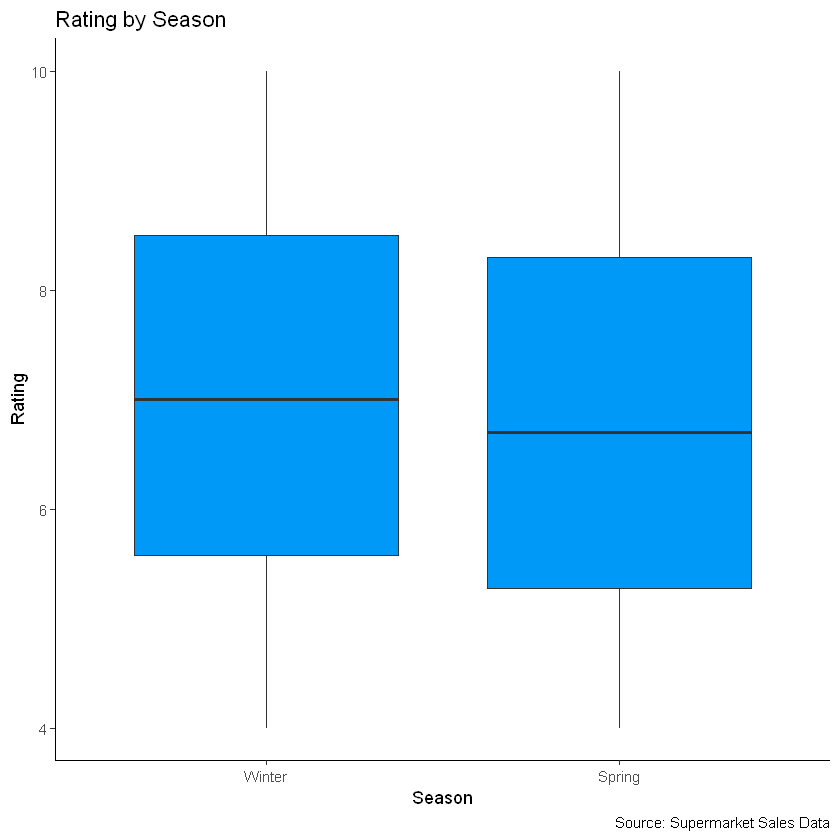

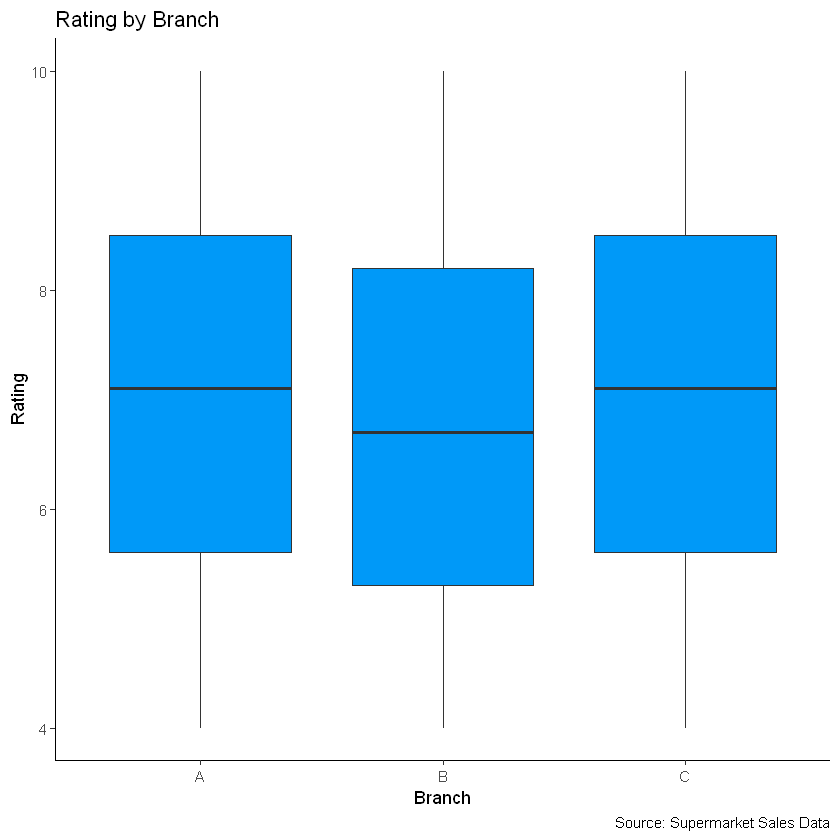

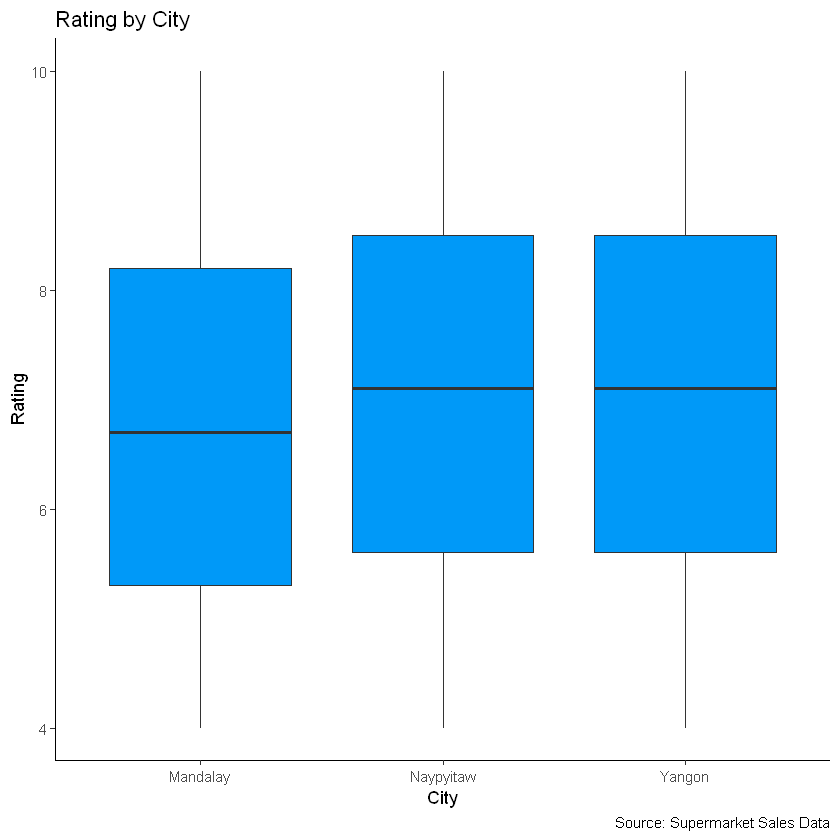

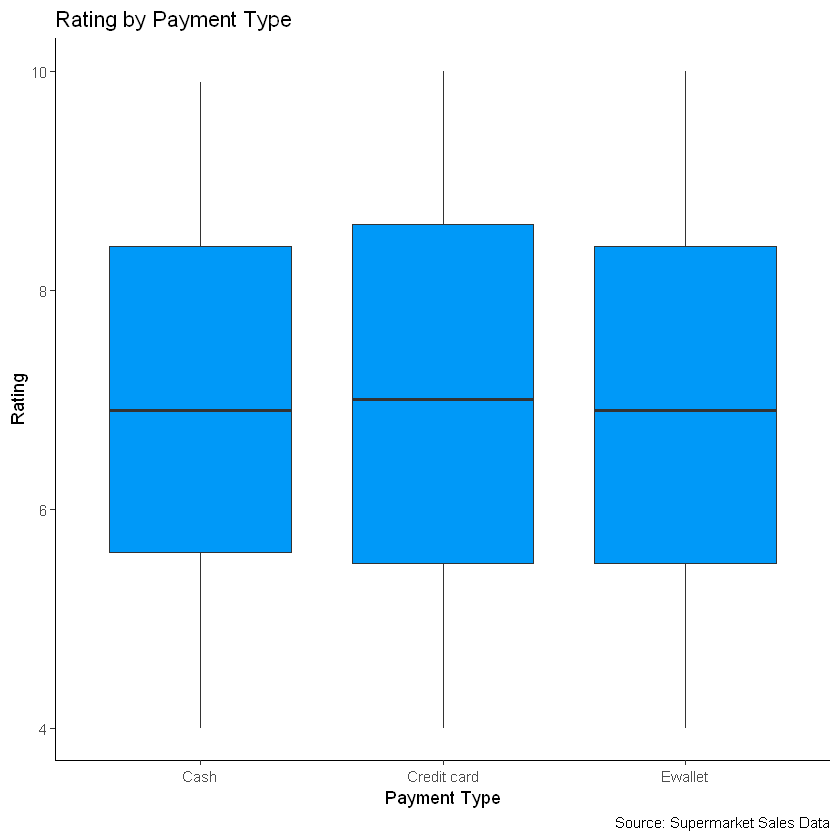

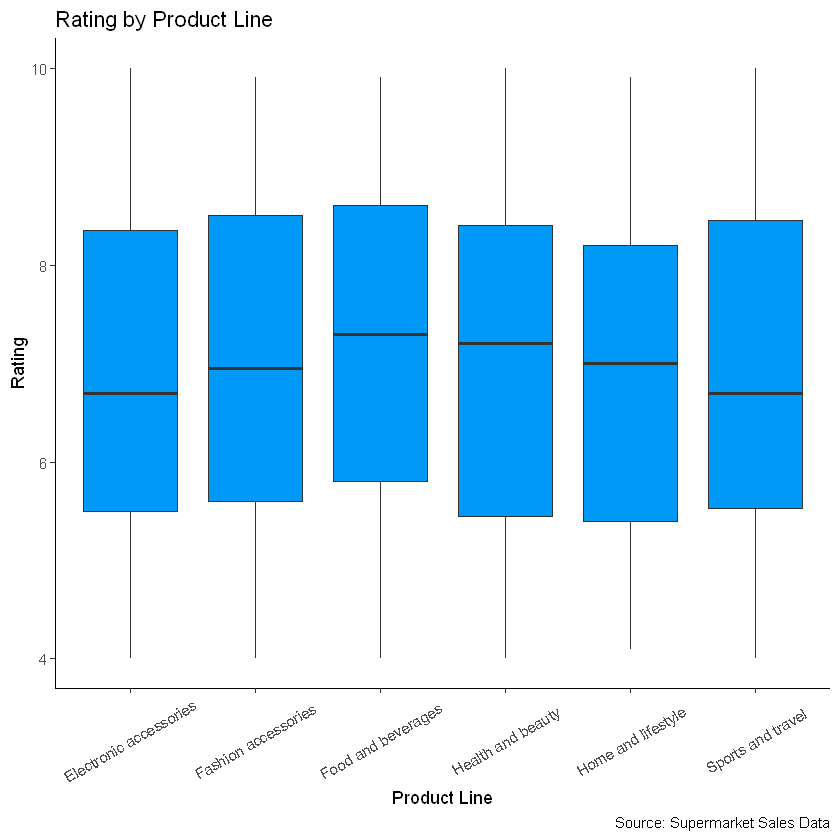

In [13]:
y_columns <- c('Total','Quantity','Unit_price','Rating')
x_columns <- c('Customer_type','City','Gender','weekday','season','Branch','City','Payment','Product_line')
#Because the column name may not be suitable in a label in the plot, I create a dictionary where the key is the
#name of the column in the dataframe and the value is the name I want in the dataframe
y_dict <- c('Total'='Total Purchased Amount in USD','Quantity'='Quantity','Unit_price'='Unit Price in USD',
            'Rating'='Rating')
for (yval in y_columns){
    for (xval in x_columns){
        #Create temporary variables for storing title and xlab and ylab
        title_val = paste(y_dict[yval],x_dict[xval],sep=' by ')
        print(ggplot(supermarket_sales, aes_string(x = xval, y = yval)) +
          geom_boxplot(fill = "#0099f8") +
          labs(
            title = title_val,
            caption = "Source: Supermarket Sales Data",
            x = x_dict[xval],
            y = y_dict[yval]
          ) +
        #Rotate only for the product line plots
        if (xval == 'Product_line'){
              theme(panel.background = element_rect(fill = "white",
                                size = 0.5, linetype = "solid"), axis.line = element_line(color="black", size = 0.5), axis.text.x = element_text(angle = 30, hjust = 0.5, vjust = 0.5))
        }else{
            theme_classic()
        }
              )
    }
    
} 

The previous indicates there is some interesting variation in the following domains:

- Rating by weekday
- Rating by city
- Unit price by weekday
- Quantity by weekday
- Quantity by gender
- Quantity by city
- Quantity by branch
- Quantity by season
- Rating by branch
- Unit price by product line
- Rating by product line
- Total amount by weekday

I keep that in mind for future analysis.

Another useful visualization technique is to understand the correlation among variables. To do so, I only use numerical variables.

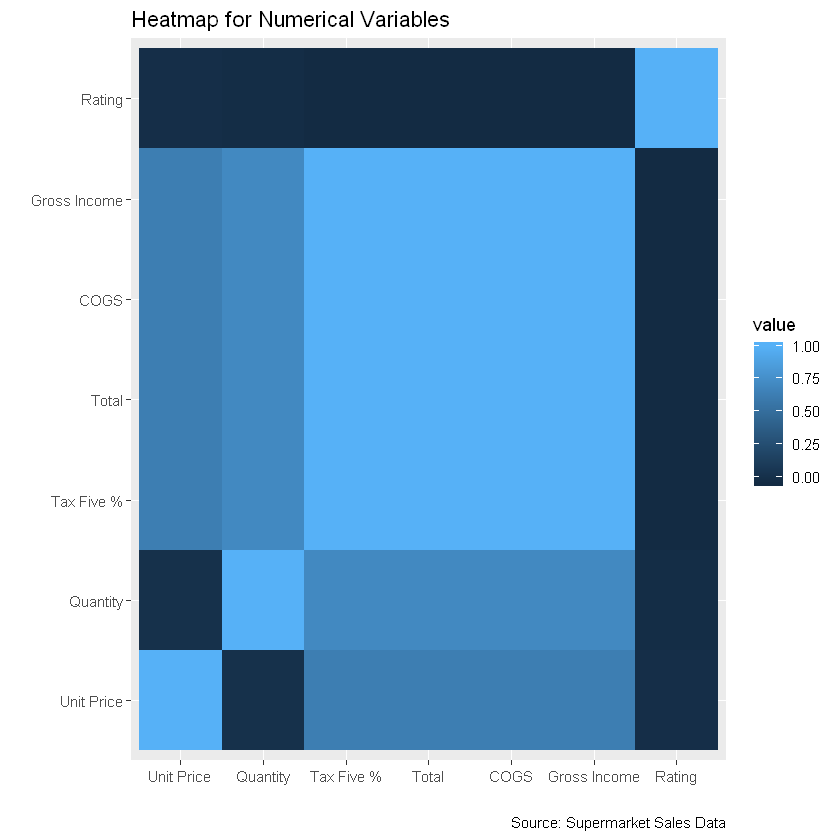

In [15]:
#I eliminate gross_margin_percentage from consideration because it has no variation
numerical_columns <- numerical_columns[!numerical_columns == 'gross_margin_percentage']
#Compute the correlation matrix and use melt to format it for the heatmap
cormat <- round(cor(supermarket_sales[,numerical_columns]),2)
melted_cormat <- melt(cormat)
#Change the names into pretty names for formatting
melted_cormat <- melted_cormat %>%
  mutate(Var1 = recode(Var1, 'Unit_price' = 'Unit Price', 'cogs' = 'COGS', 'gross_income' = 'Gross Income',
                       'Tax_Five' = 'Tax Five %'),
         Var2 = recode(Var2, 'Unit_price' = 'Unit Price', 'cogs' = 'COGS', 'gross_income' = 'Gross Income',
                       'Tax_Five' = 'Tax Five %'))
#heatmap(cormat)
ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile() +labs(title = "Heatmap for Numerical Variables", caption = "Source: Supermarket Sales Data",x = "",y = "")

From the heatmap, it follows that there is some relationship between quantity and the purchasing metrics (total, tax, etc...), that can be an interesting venue for further exploration.

Rating does not seem to have a strong connection to any numerical variable, which indicates that rating might be related to the other categorical variables that were omitted here.

## Time Series Analysis

Because purchasing habits can be driven by time variables, I turn my attention to understanding the variation of the variables as a function of the week in which the purchase happened. I use week as my time variable because of the narrow range of the dates in the dataset.

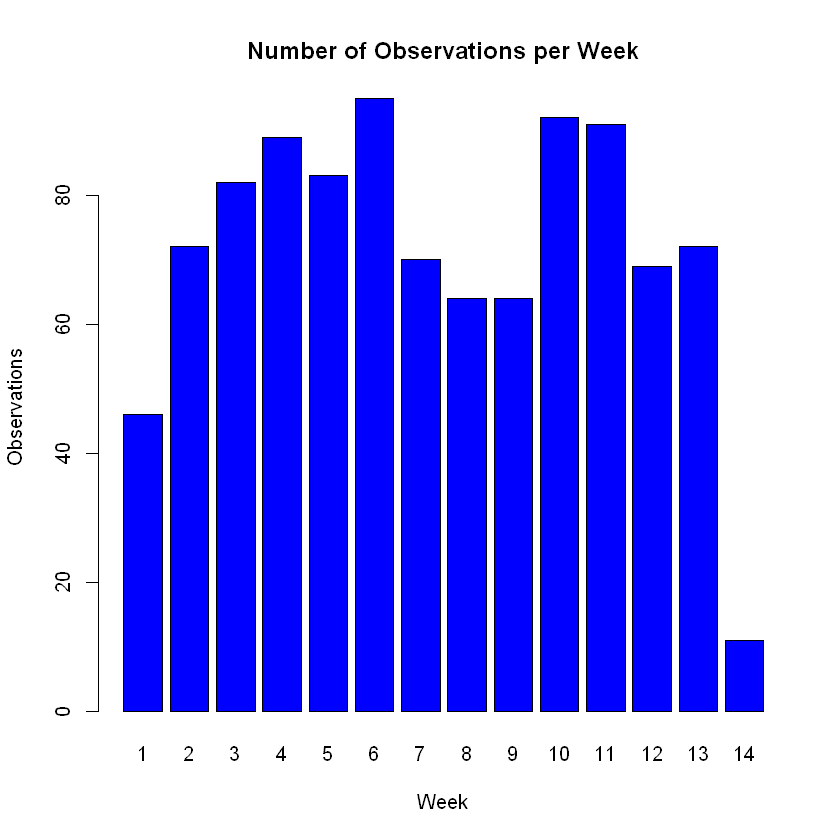

In [16]:
#Extract month as number from date I also do this in a way that is independent from the computer's language
supermarket_sales$Month <- format(supermarket_sales$Date,"%m")
#Transform into string
supermarket_sales <- supermarket_sales %>%
  mutate(Month = recode(Month, '01' = 'January', '02' = 'February', '03' = 'March'))
supermarket_sales$Month <- factor(supermarket_sales$Month, order = TRUE, 
                                   levels =c('January','February','March'))
#Because the dates are clustered on three months on the same year, working by month is not as relevant
#Therefore, it may be relevant to understand how the variables change depending on the week
supermarket_sales = supermarket_sales %>% 
  mutate(Week = cut.Date(Date, breaks = "1 week", labels = FALSE)) %>% 
  arrange(Date)
#We can investigate how many observations each week has 
#This is because if they are unbalanced, then it might not be a useful proxy for time
#Create frequency table
freqWeekTable <- table(supermarket_sales$Week)
#Represent with barplot
barplot(height=freqWeekTable,xlab="Week",ylab="Observations",main="Number of Observations per Week",col="blue")

Most weeks are balanced in terms of observations, except for the first and last.

I proceed by doing an analysis of the aggregate of the variables of interest by week.

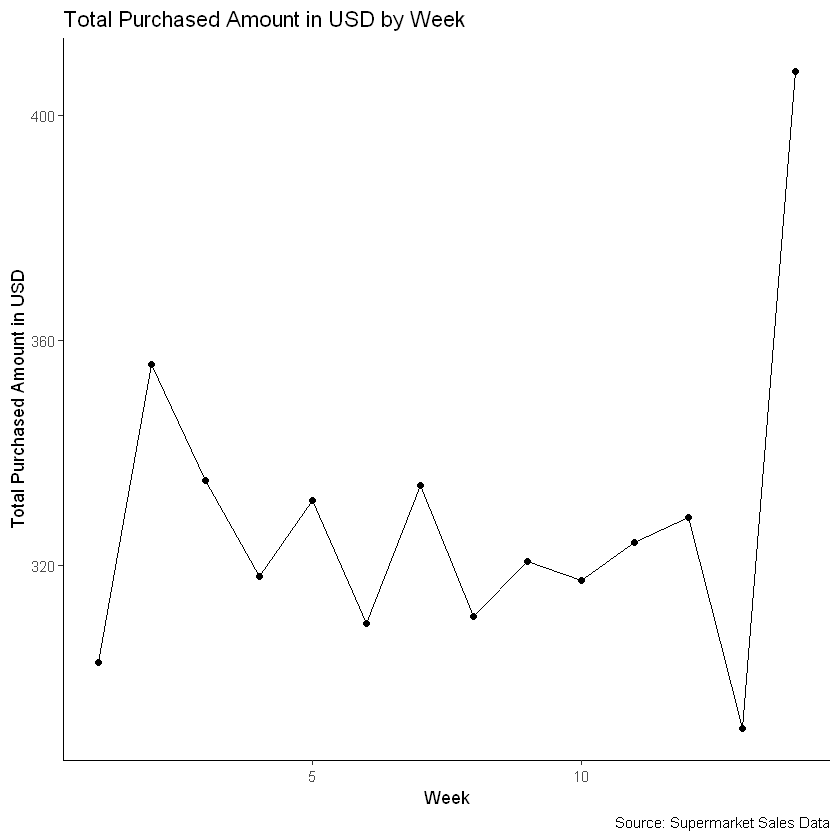

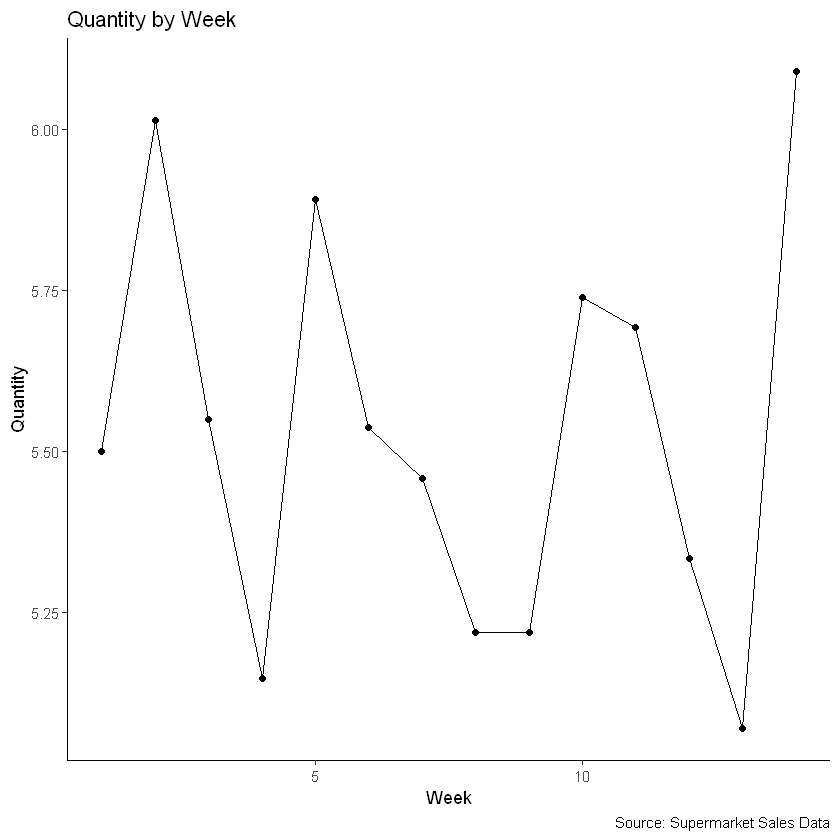

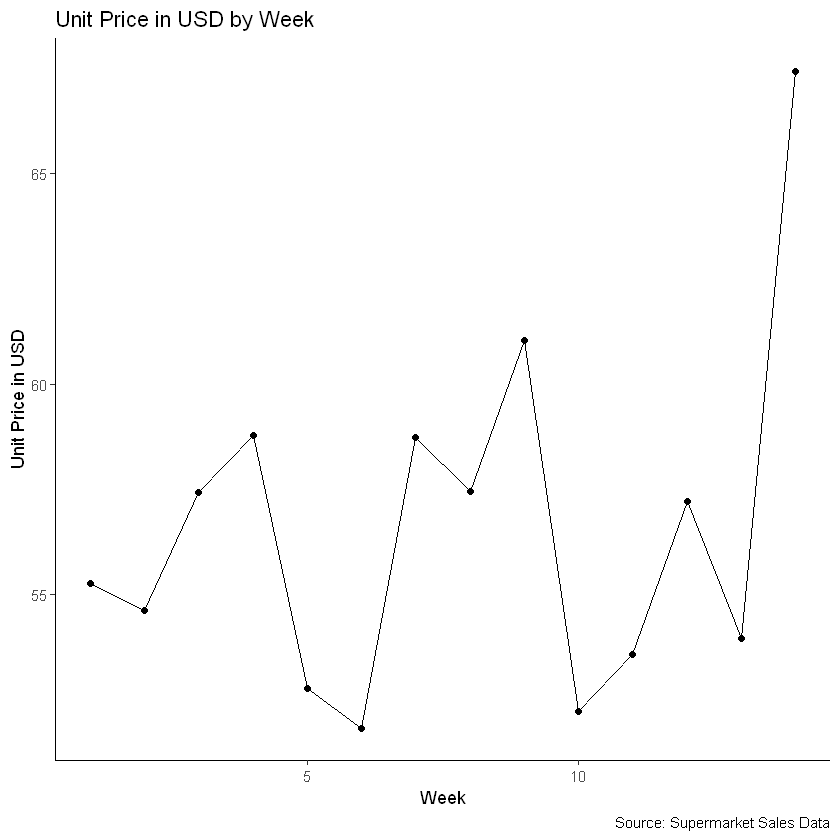

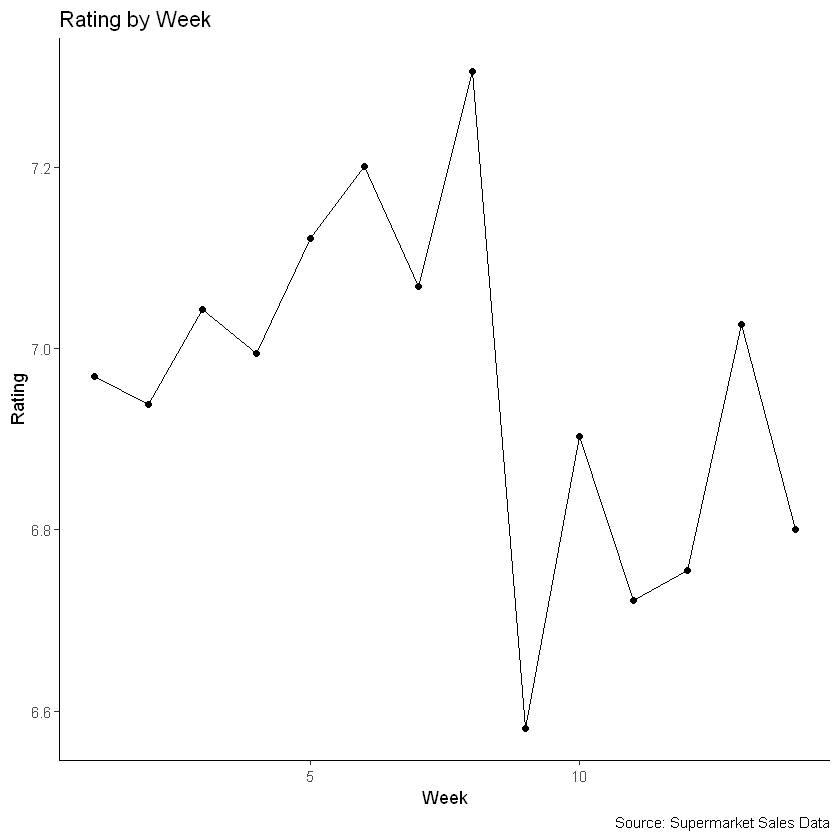

In [17]:
#Get an aggregate per variables of interest
for (yval in y_columns){
    #Create temporary variables for storing title and xlab and ylab
    title_val = paste(y_dict[yval],"Week",sep=' by ')
    #Create temporary database
    df_temp <- aggregate(supermarket_sales[,yval], supermarket_sales[,'Week'], FUN=mean) 
    print(ggplot(df_temp, aes_string(x = "Week", y = yval)) + geom_line() + geom_point() +
      labs(
        title = title_val,
        caption = "Source: Supermarket Sales Data",
        x = "Week",
        y = y_dict[yval]
      ) + theme_classic())
} 

There does not seem to be any clear trend, but there is substantial variation among the variables of interest.

I want to visualize the variation of the weekly mean of total sales. I want to analyze whether the averages change depending on the location (*city* and *branch*) and the gender of the client (*gender*). In order to do so, I first define an auxiliary function that aids in preparing the data.

In [18]:
#Define auxiliary function to get mean and std dev for the data
data_summary <- function(data, varname, groupnames){
  require(plyr)
  summary_func <- function(x, col){
    c(mean = mean(x[[col]], na.rm=TRUE),
      sd = sd(x[[col]], na.rm=TRUE))
  }
  data_sum<-ddply(data, groupnames, .fun=summary_func,
                  varname)
 return(data_sum)}

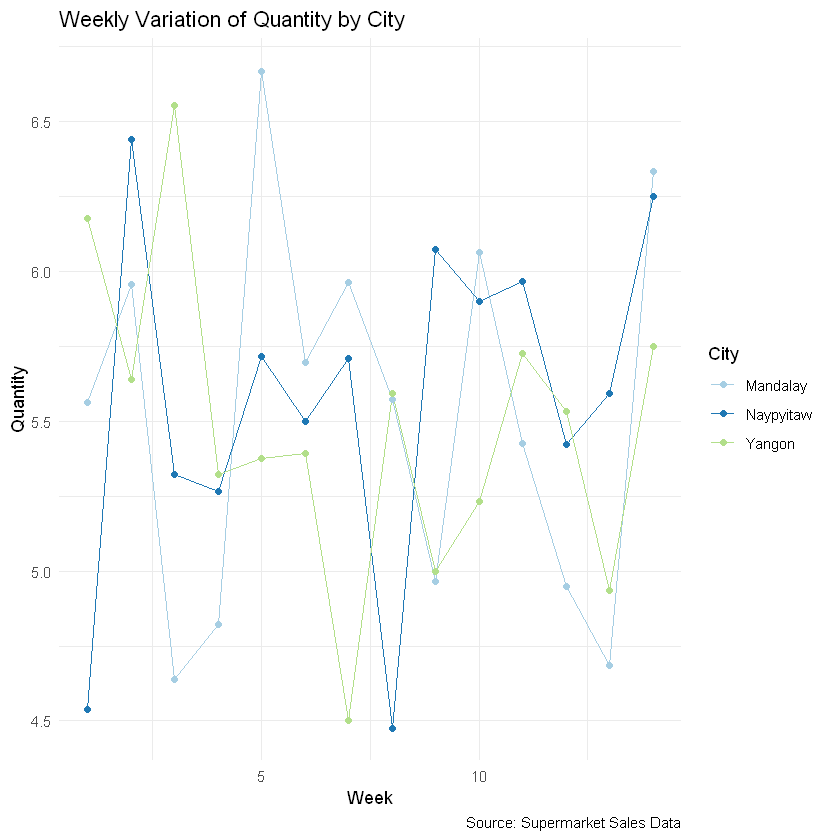

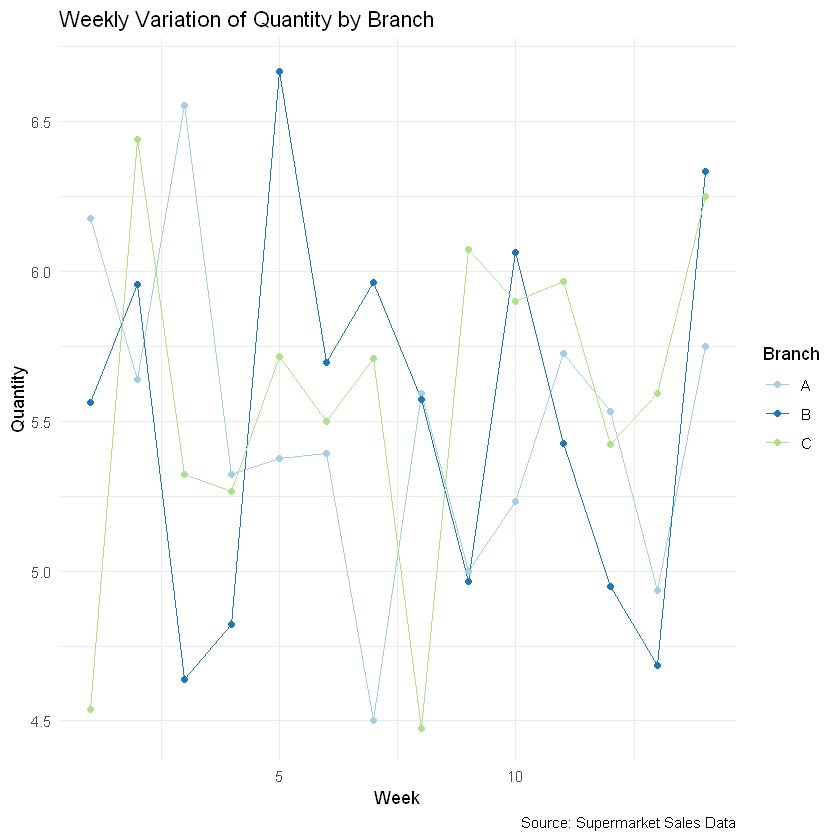

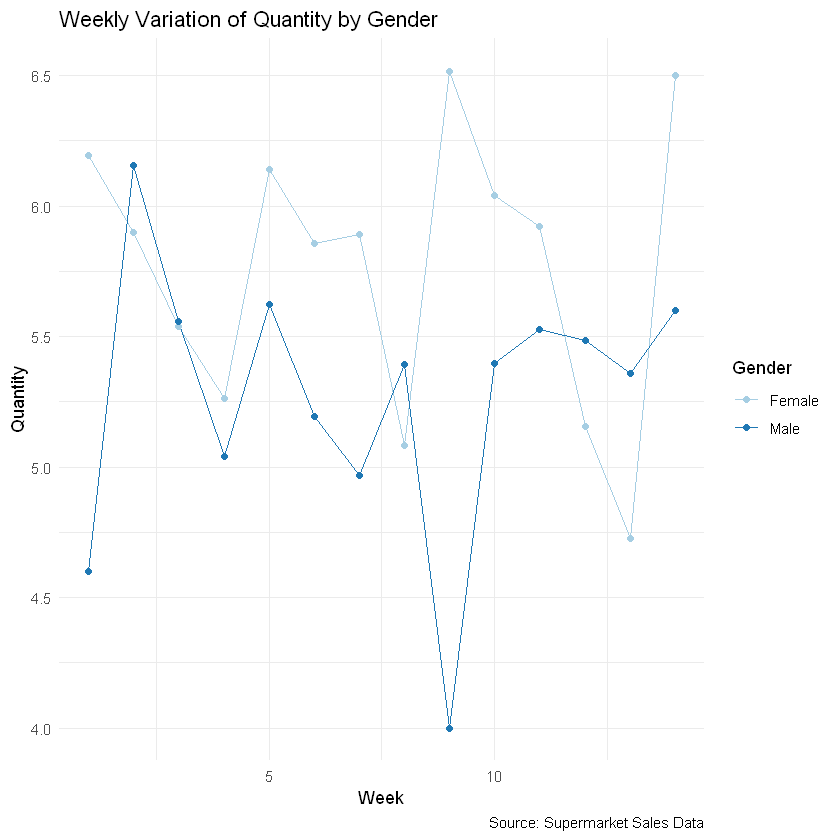

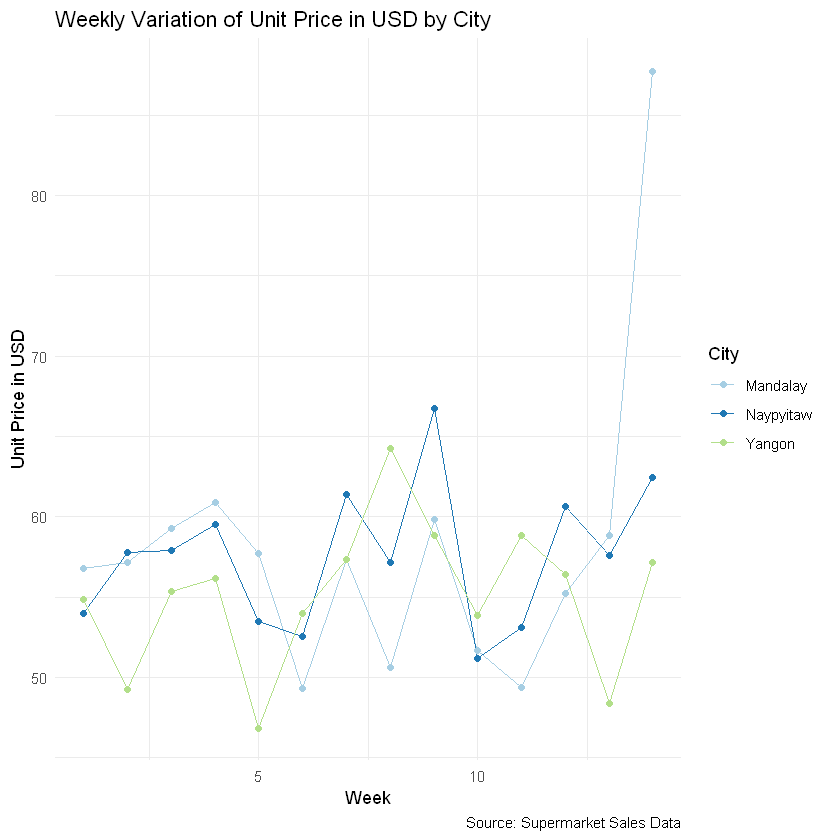

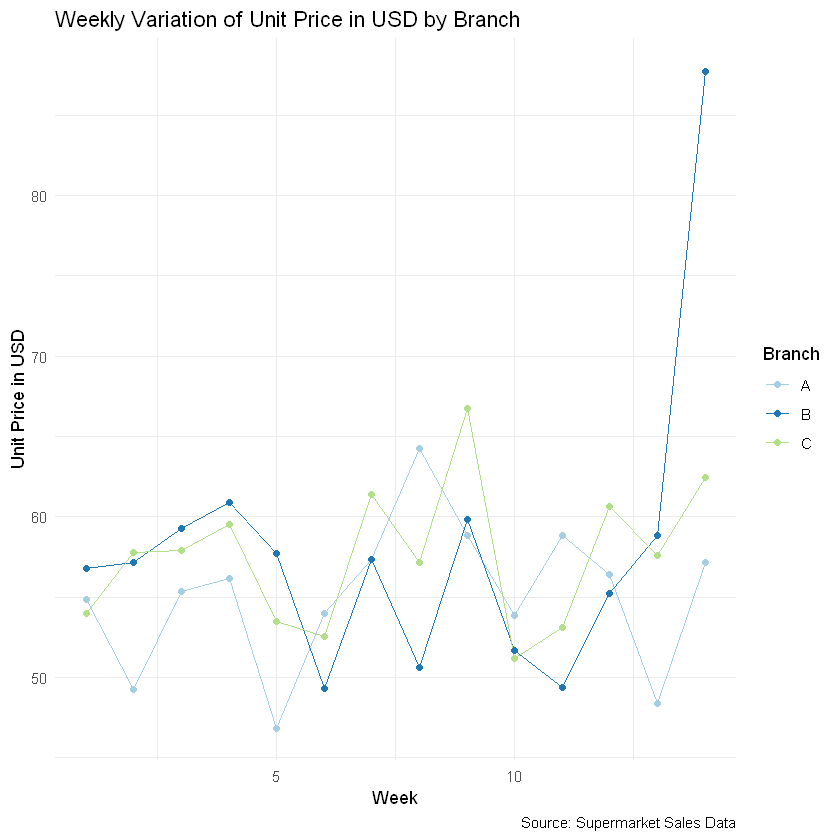

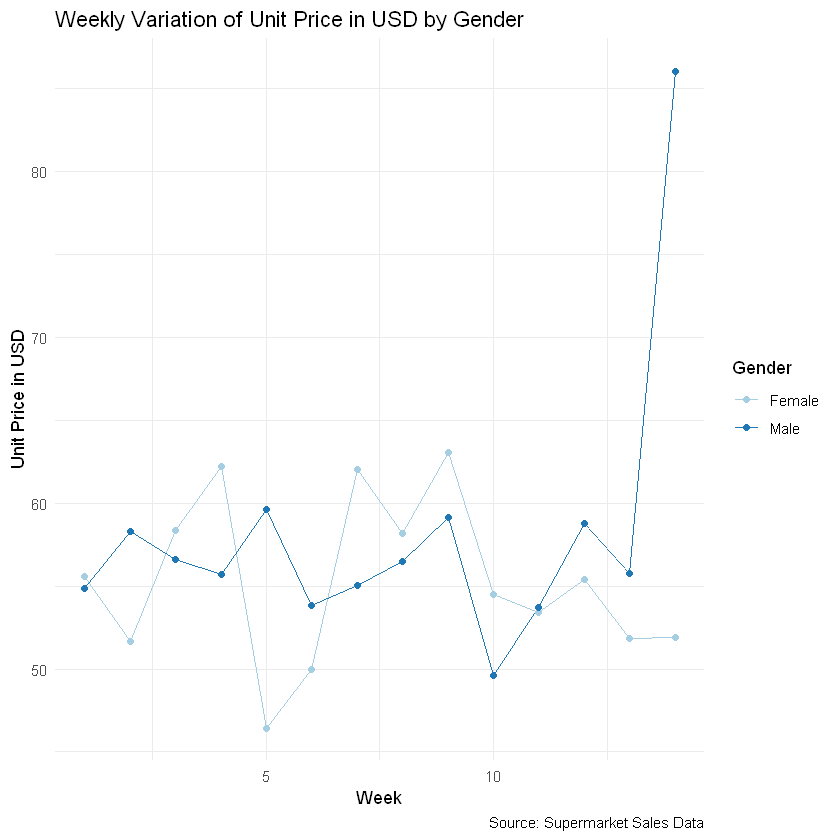

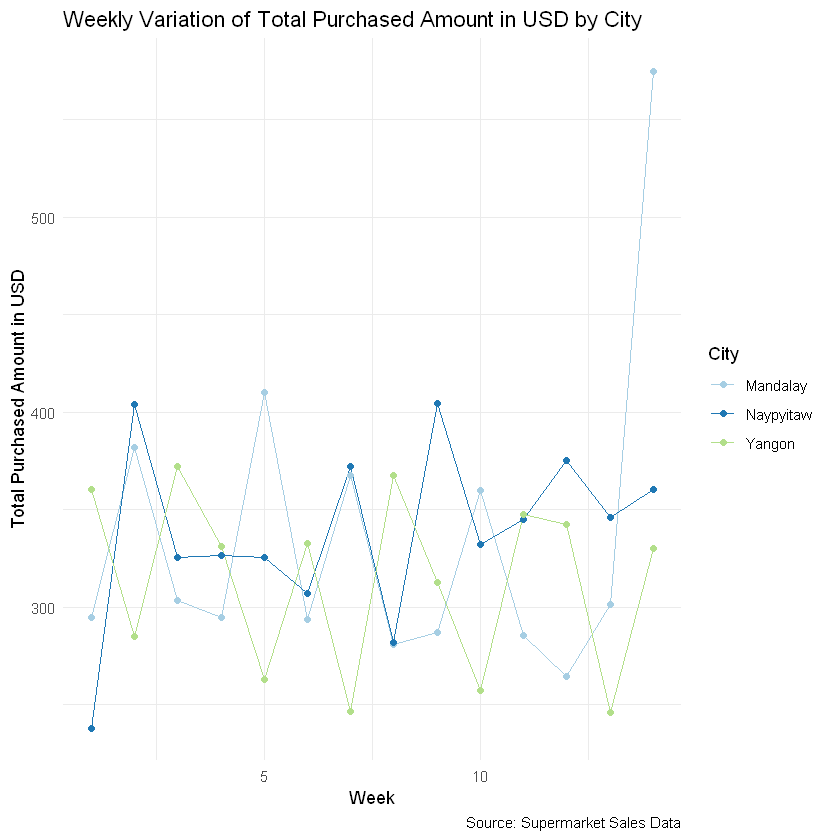

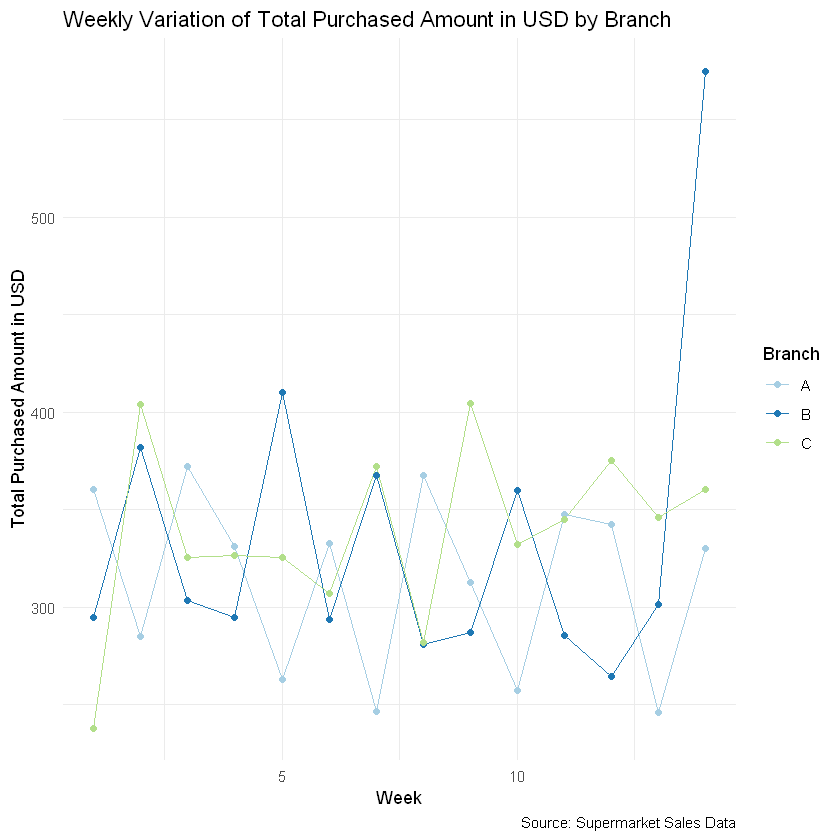

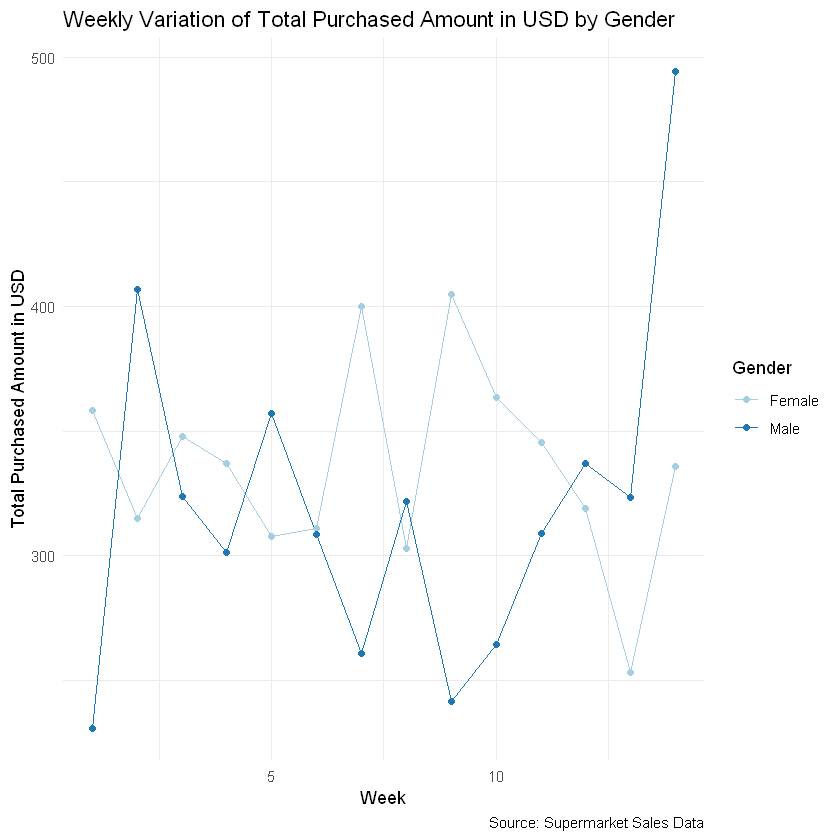

In [19]:
#Iterate for the variables of interest and for groups of interest
dep_vars <- c("Quantity","Unit_price","Total")
group_vars <- c("City","Branch","Gender")
for (yval in dep_vars){
    for (g in group_vars){
        #Create title
        title_val = paste("Weekly Variation of",y_dict[yval])
        title_val = paste(title_val,g,sep=' by ')
        #Create summary database
        df_temp <- data_summary(supermarket_sales, varname=yval, 
                            groupnames=c(g,"Week"))
        #Plot
        print(ggplot(df_temp, aes_string(x="Week", y="mean", group=g, color=g)) + 
            geom_line() + geom_point()+
           scale_color_brewer(palette="Paired")+theme_minimal() + labs(
        title = title_val,
        caption = "Source: Supermarket Sales Data",
        x = "Week",
        y = y_dict[yval]
      ))
    }
}
#Again, substantial variation but nothing too clear

From the graphs, I gather that there is a significant amount of variation in the quantity.

## Regression Analysis

So far, I have done descriptives with the data and taken a look at how some variables may vary over time. Recall from the boxplots, that there seemed to be a sizable variation in the purchased quantity by *weekday*, *gender*, *city*, *branch* and *season*.

To explore the behaviour of the data beyond visualization, I conduct linear regression to explore further intowhat drives the total purchased amount and quantity of items purchased.

Because if I used all the variables we would run into the problem of multi-collinearity, I will first conduct regressions using intuition of which variable affects which other variable and then run LASSO to identify which of the variables in the dataframe I maintain for my analysis.

As a refresher, I start by remembering the variables in the dataset.

In [20]:
head(supermarket_sales)
print(colnames(supermarket_sales))

Invoice_ID,Branch,City,Customer_type,Gender,Product_line,Unit_price,Quantity,Tax_Five,Total,...,Payment,cogs,gross_margin_percentage,gross_income,Rating,season,weekday,TimeOfDay,Month,Week
765-26-6951,A,Yangon,Normal,Male,Sports and travel,72.61,6,21.783,457.443,...,Credit card,435.66,4.761905,21.783,6.9,Winter,Wednesday,Morning,January,1
530-90-9855,A,Yangon,Member,Male,Home and lifestyle,47.59,8,19.036,399.756,...,Cash,380.72,4.761905,19.036,5.7,Winter,Wednesday,Afternoon,January,1
891-01-7034,B,Mandalay,Normal,Female,Electronic accessories,74.71,6,22.413,470.673,...,Cash,448.26,4.761905,22.413,6.7,Winter,Wednesday,Evening,January,1
493-65-6248,C,Naypyitaw,Member,Female,Sports and travel,36.98,10,18.490,388.290,...,Credit card,369.80,4.761905,18.490,7.0,Winter,Wednesday,Evening,January,1
556-97-7101,C,Naypyitaw,Normal,Female,Electronic accessories,63.22,2,6.322,132.762,...,Cash,126.44,4.761905,6.322,8.5,Winter,Wednesday,Afternoon,January,1
133-14-7229,C,Naypyitaw,Normal,Male,Health and beauty,62.87,2,6.287,132.027,...,Cash,125.74,4.761905,6.287,5.0,Winter,Wednesday,Morning,January,1


 [1] "Invoice_ID"              "Branch"                 
 [3] "City"                    "Customer_type"          
 [5] "Gender"                  "Product_line"           
 [7] "Unit_price"              "Quantity"               
 [9] "Tax_Five"                "Total"                  
[11] "Date"                    "Time"                   
[13] "Payment"                 "cogs"                   
[15] "gross_margin_percentage" "gross_income"           
[17] "Rating"                  "season"                 
[19] "weekday"                 "TimeOfDay"              
[21] "Month"                   "Week"                   


Thinking about what could affect the total amount purchased, the follow are some possible venues for explotarion:

- The *branch* and *city* are candidates because they can be seen as proxies for the socio-economic status of the people who go to the store
- *Customer_type* can be understood as a proxy of how often they attend the store
- *Gender* could be a potential source of variation in total purchased amount
- *Product_line* is a reasonable assumption, because different product lines have inherently more expensive products than others
- *Payment* can also be indicative of how big a purchase will be (cash for a purchase of a smaller amount)
- Time could be relevant, so I proxy it by using *weekday* and *season*

A useful preliminary procedure is to consider how the week variable can enter into the regression models. One way would be to simply consider it as it is, that is, as an integer variable that increments with one. The problem with that is that it does not carry much meaning. Recall from the visualization plots that there did not seem to be any clear pattern between weeks, although there was substantial variation among them.

Because of the above, I consider weeks in two ways: the first is just using the variable as is and the other is as a fixed effect. That notion requires me to create a categorical variable for the weeks

In [21]:
supermarket_sales$WeekCategorical <- factor(supermarket_sales$Week,order=TRUE)

I want to focus first on whether the quantity of items purchased depends on certain factors. I am first interested in seeing if there is a difference per product type

In [22]:
lmQuant1 = lm(Quantity~Product_line,data = supermarket_sales)
#Type of payment could also incide (because those who pay with credit are presumably wealthy)
#Maybe gender also plays a role
lmQuant2 = lm(Quantity~Product_line + Payment + Gender,data = supermarket_sales)
#Time variables such as time of day and which week the observation corresponds to could be relevant
#I include Branch as a location variable and unit price as a way to control for how expensive the product is
lmQuant3 = lm(Quantity~Product_line + Payment + Gender + TimeOfDay + Branch + Unit_price + Week,data = supermarket_sales)
#Replace week with the categorical variable representation
lmQuant4 = lm(Quantity~Product_line + Payment + Gender + TimeOfDay + Branch + Unit_price + WeekCategorical,
              data = supermarket_sales)
#Show all the regressions together
stargazer(lmQuant1, lmQuant2, lmQuant3, lmQuant4, header=FALSE,type="text")


                                                               Dependent variable:                               
                                ---------------------------------------------------------------------------------
                                                                    Quantity                                     
                                        (1)                 (2)                 (3)                  (4)         
-----------------------------------------------------------------------------------------------------------------
Product_lineFashion accessories      -0.644**            -0.667**             -0.694**             -0.683**      
                                      (0.313)             (0.314)             (0.315)              (0.317)       
                                                                                                                 
Product_lineFood and beverages        -0.241              -0.254               -0.284  

It seems that compared to the baseline category of electronic accessories, the only product type that has a lower purchased quantity is fashion and accessories. Of all the other variables considered, only gender ended up being relevant. With males purchasing -0.451 less units than females when all else is equal. The only week that has a significant impact is the seventh week and it may be because of a purchase outlier.

To see if there is any interesting variation, I repeat the analysis with *total* as the dependent variable. You may peek at the table and wonder *What about the unit price?* I omitted it here because total is a direct result of unit price: it is pretty straight-forward that the higher the unit price, the higher the total of the sale. Therefore, I can avoid colinearity by not including it.

In [23]:
#Prepare regression models
lmTot1 = lm(Total~Product_line,data = supermarket_sales)
lmTot2 = lm(Total~Product_line + Payment + Gender,data = supermarket_sales)
lmTot3 = lm(Total~Product_line + Payment + Gender + TimeOfDay + Branch + Week,data = supermarket_sales)
lmTot4 = lm(Total~Product_line + Payment + Gender + TimeOfDay + Branch + WeekCategorical,data = supermarket_sales)
#Show all the regressions together
stargazer(lmTot1, lmTot2, lmTot3, lmTot4, header=FALSE,type="text")


                                                               Dependent variable:                               
                                ---------------------------------------------------------------------------------
                                                                      Total                                      
                                        (1)                 (2)                 (3)                  (4)         
-----------------------------------------------------------------------------------------------------------------
Product_lineFashion accessories       -14.543             -15.223             -17.635              -18.818       
                                     (26.412)            (26.476)             (26.566)             (26.768)      
                                                                                                                 
Product_lineFood and beverages         3.039               2.712               -0.484  

Surprisingly enough, none of the variables are relevant.

Another interesting venue to explore is the rating. Because *rating* is a categorical variable, a logistical regression is better suited for it. I first visualize the distribution of *rating* to understand more of that variable before doing any process on it.

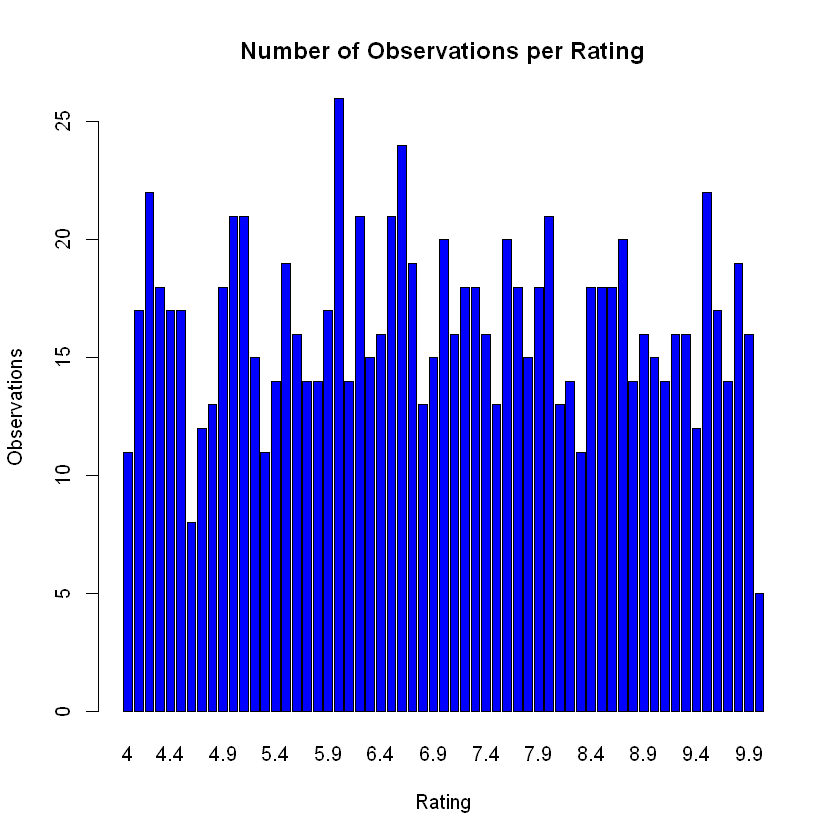

In [24]:
freqRatingTable <- table(supermarket_sales$Rating)
#Represent with barplot
barplot(height=freqRatingTable,xlab="Rating",ylab="Observations",main="Number of Observations per Rating",col="blue")

There is sizable variation, I am interested in understanding if there is a connection between the rating and the total purchased amount. I first visualize their behaviour.

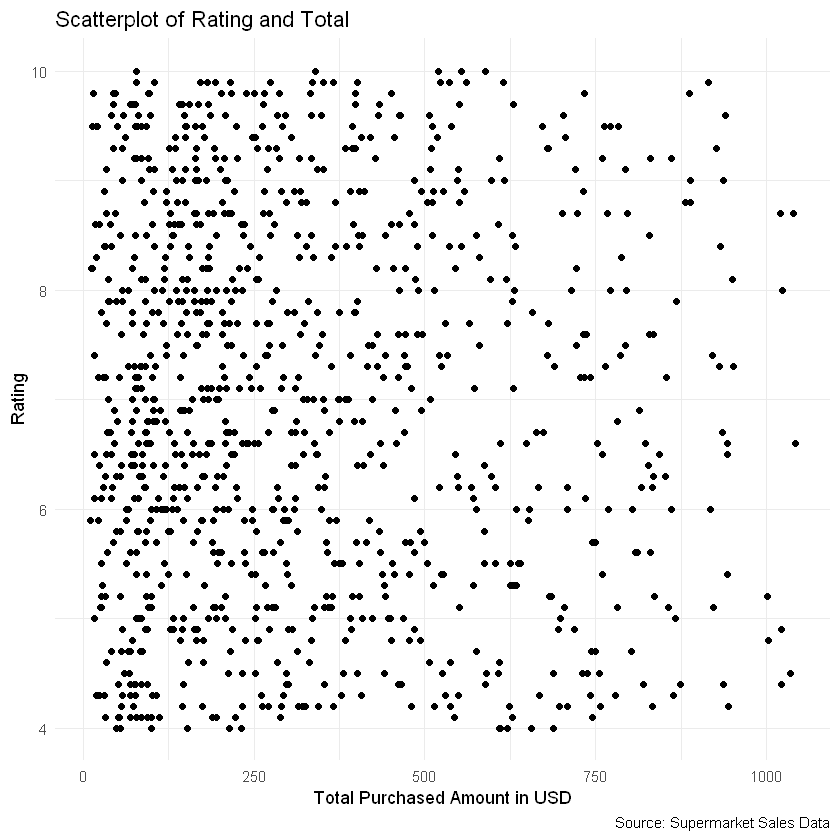

In [25]:
ggplot(supermarket_sales, aes_string(x="Total", y="Rating")) + 
    labs(title = "Scatterplot of Rating and Total",
        caption = "Source: Supermarket Sales Data",
        x = "Total Purchased Amount in USD",
        y = "Rating") +
     geom_point()+
    scale_color_brewer(palette="Paired")+theme_minimal()

There is sizable variation. I  proceed by grouping ratings together per integer. For example, any rating between 6.0 and 6.9 gets graded.

In [26]:
supermarket_sales$RatingRound <- round(supermarket_sales$Rating)
supermarket_sales$RatingRound <- factor(supermarket_sales$RatingRound, order = TRUE, 
                                   levels =c(4,5,6,7,8,9,10))

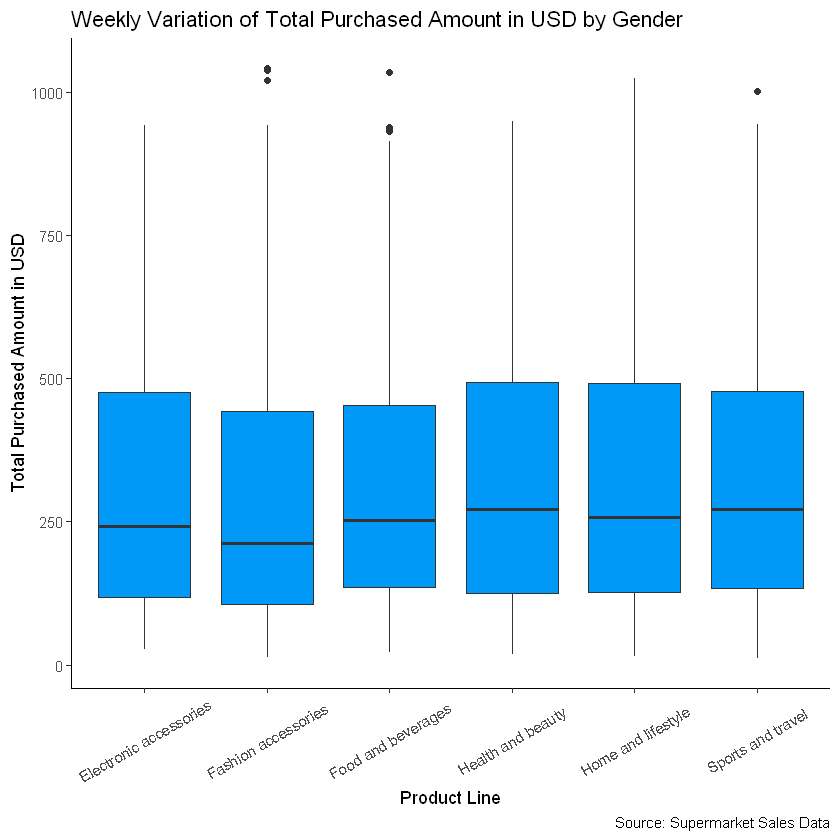

In [27]:
print(ggplot(supermarket_sales, aes_string(x = xval, y = yval)) +
          geom_boxplot(fill = "#0099f8") +
          labs(
            title = title_val,
            caption = "Source: Supermarket Sales Data",
            x = x_dict[xval],
            y = y_dict[yval]
          ) +
        #Rotate only for the product line plots
        if (xval == 'Product_line'){
              theme(panel.background = element_rect(fill = "white",
                                size = 0.5, linetype = "solid"), axis.line = element_line(color="black", size = 0.5), axis.text.x = element_text(angle = 30, hjust = 0.5, vjust = 0.5))
        }else{
            theme_classic()
        }
              )

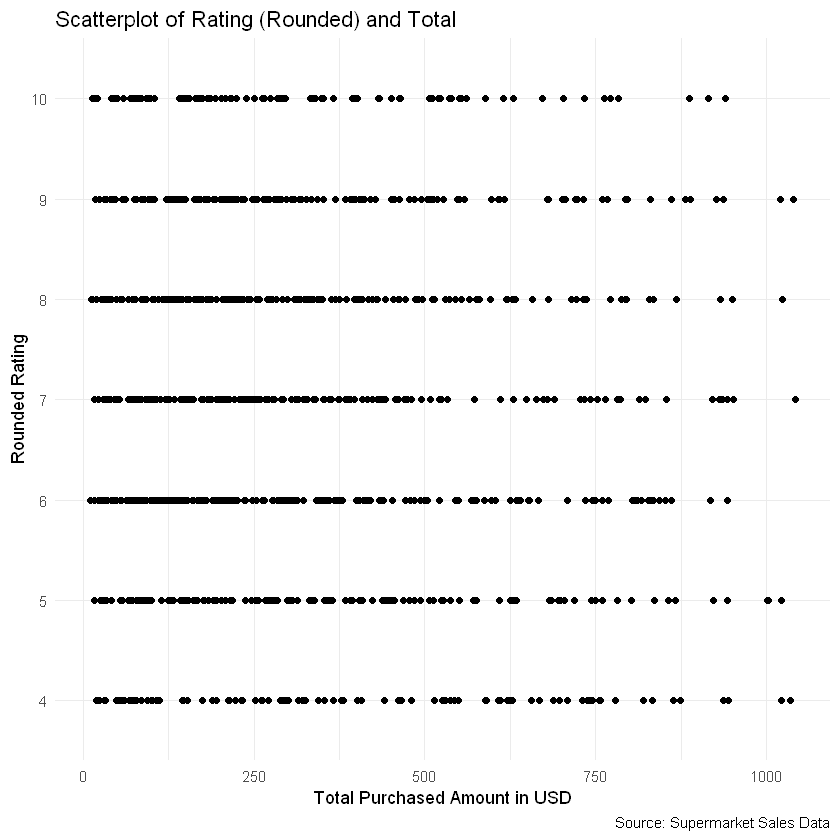

In [28]:
#Visualize this new behaviour
ggplot(supermarket_sales, aes_string(x="Total", y="RatingRound")) + 
    labs(title = "Scatterplot of Rating (Rounded) and Total",
        caption = "Source: Supermarket Sales Data",
        x = "Total Purchased Amount in USD",
        y = "Rounded Rating") +
     geom_point()+
    scale_color_brewer(palette="Paired")+theme_minimal()
#More uniformity as expected, but still no clear pattern

Note: I am aware that scatter-plotting a categorical variable is silly. I was mostly concerned with understanding whether one of the ratings had a clustering of values in either an extreme low (total purchased amount close to 0) or an extreme high (total purchased amount close to 1000).

I am interested in seeing if there is any effect of the total amount purchased in the rating the customer gave to the store. I use a logistic regression for that purpose.

In [29]:
logRatingBasic = multinom(RatingRound ~ Total,data = supermarket_sales)
#summary(logRatingBasic)
stargazer(logRatingBasic, header=FALSE,type="text")

# weights:  21 (12 variable)
initial  value 1945.910149 
iter  10 value 1927.303983
final  value 1912.513704 
converged

                                      Dependent variable:                    
                  -----------------------------------------------------------
                      5         6         7         8         9        10    
                     (1)       (2)       (3)       (4)       (5)       (6)   
-----------------------------------------------------------------------------
Total              -0.0004  -0.001**   -0.001*   -0.001*   -0.0004   -0.001* 
                   (0.001)  (0.0005)   (0.001)  (0.0005)   (0.001)   (0.001) 
                                                                             
Constant           0.407*   0.974***  0.750***  0.867***   0.478**    0.261  
                   (0.224)   (0.207)   (0.215)   (0.210)   (0.221)   (0.240) 
                                                                             
---------------------

Try more variables.

In [30]:
logRating = multinom(RatingRound ~ Total + Branch + City + Gender + Customer_type + Product_line + WeekCategorical
                     ,data = supermarket_sales)
stargazer(logRating, header=FALSE,type="text")
#It seems that the city plays a role in some ratings, as well as the branch, gender and type of product
#The week fixed effects also yield significant values for certain weeks

# weights:  189 (156 variable)
initial  value 1945.910149 
iter  10 value 1892.144611
iter  20 value 1859.152275
iter  30 value 1854.472221
iter  40 value 1854.217192
iter  50 value 1854.162399
iter  60 value 1854.122710
iter  70 value 1854.100096
iter  80 value 1854.082368
iter  90 value 1854.076713
iter 100 value 1854.074564
final  value 1854.074564 
stopped after 100 iterations

                                                    Dependent variable:                    
                                -----------------------------------------------------------
                                    5         6         7         8         9        10    
                                   (1)       (2)       (3)       (4)       (5)       (6)   
-------------------------------------------------------------------------------------------
Total                            -0.0004  -0.001**   -0.001*   -0.001*   -0.0004   -0.001* 
                                 (0.001)  (0.0005)   (0.001)  (

The previous assumes that each category is seen in the same way for all people: that is, a 5 is unambiguously a 5 for everyone in the dataset. Because that may not be entirely true, I consider 5 categories of ratings:

1. Awful (bottom 5 percentile) 
2. Bad (between 5 and 25 percentile) 
3. Mid-low (26 to 50 percentile)
4. Mid-high (51 to 75 percentile) 
5. Good (75 to 95 percentile) 
6. Excellent (95 percentile onwards)

In [31]:
#Get percentiles
percentiles <- quantile(supermarket_sales$Rating,probs=c(0.05,0.25,0.5,0.75,0.95,1))
#Add to database with mutate
supermarket_sales <- supermarket_sales %>% mutate(RatingLabels =
                     case_when(Rating <= percentiles[[1]] ~ "Awful", 
                               Rating <= percentiles[[2]] ~ "Bad",
                               Rating <= percentiles[[3]] ~ "Mid-Low",
                               Rating <= percentiles[[4]] ~ "Mid-High",
                               Rating <= percentiles[[5]] ~ "Good",
                               Rating <= percentiles[[6]] ~ "Excellent")
)
#Make it an ordinal factor
supermarket_sales$RatingLabels <- factor(supermarket_sales$RatingLabels, order = TRUE, 
                                   levels =c('Awful','Bad','Mid-Low','Mid-High','Good','Excellent'))

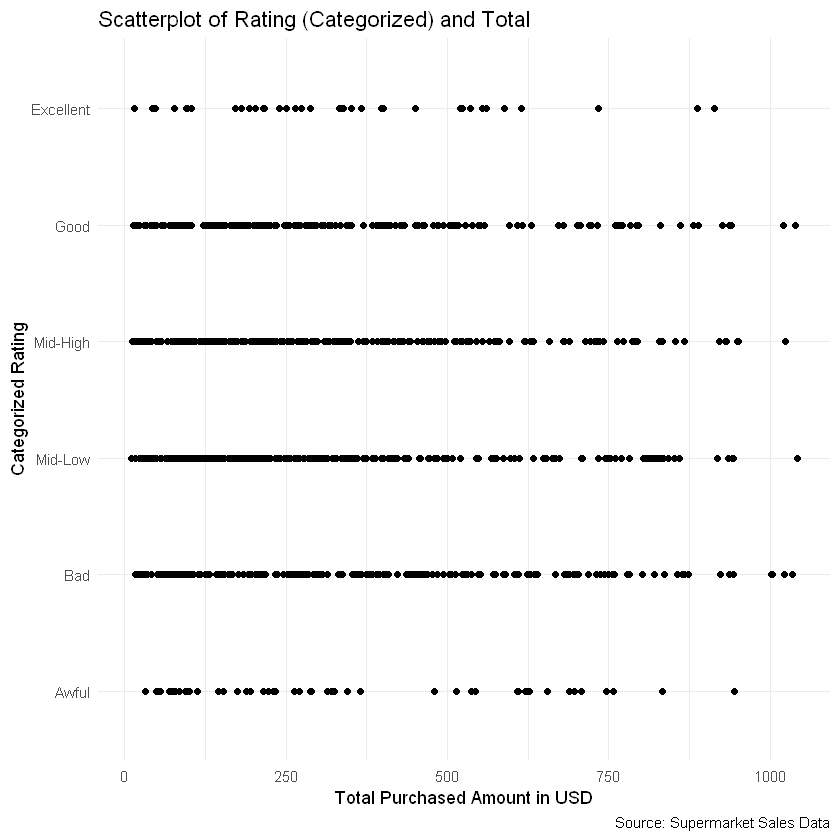

In [32]:
#Visualize
ggplot(supermarket_sales, aes_string(x="Total", y="RatingLabels")) + 
    labs(title = "Scatterplot of Rating (Categorized) and Total",
        caption = "Source: Supermarket Sales Data",
        x = "Total Purchased Amount in USD",
        y = "Categorized Rating") +
     geom_point() + scale_color_brewer(palette="Paired")+theme_minimal()
#Very similar to the rounded rating, as expected

With the previous in mind, I run the regression model.

In [33]:
#Run the basic regression
logRatingLabelsBasic = multinom(RatingLabels ~ Total,data = supermarket_sales)
stargazer(logRatingLabelsBasic, header=FALSE,type="text")
#No effect whatsoever

# weights:  18 (10 variable)
initial  value 1791.759469 
iter  10 value 1636.460344
final  value 1614.633249 
converged

                                 Dependent variable:               
                  -------------------------------------------------
                     Bad     Mid-Low  Mid-High    Good    Excellent
                     (1)       (2)       (3)       (4)       (5)   
-------------------------------------------------------------------
Total              0.0003    -0.001    -0.0003   -0.0002   -0.0002 
                   (0.001)   (0.001)   (0.001)   (0.001)   (0.001) 
                                                                   
Constant          1.297***  1.887***  1.696***  1.420***   -0.143  
                   (0.265)   (0.257)   (0.259)   (0.265)   (0.352) 
                                                                   
-------------------------------------------------------------------
Akaike Inf. Crit. 3,249.266 3,249.266 3,249.266 3,249.266 3,249

What happens with multiple variables?

In [34]:
logRatingLabels = multinom(RatingLabels ~ Total + Branch + City + Gender + Customer_type + Product_line + WeekCategorical,data = supermarket_sales)
stargazer(logRatingLabels, header=FALSE,type="text")

# weights:  162 (130 variable)
initial  value 1791.759469 
iter  10 value 1606.028780
iter  20 value 1577.823567
iter  30 value 1571.242702
iter  40 value 1570.740255
iter  50 value 1570.564819
iter  60 value 1570.493643
iter  70 value 1570.442962
iter  80 value 1570.401343
iter  90 value 1570.392982
iter 100 value 1570.392044
final  value 1570.392044 
stopped after 100 iterations

                                               Dependent variable:               
                                -------------------------------------------------
                                   Bad     Mid-Low  Mid-High    Good    Excellent
                                   (1)       (2)       (3)       (4)       (5)   
---------------------------------------------------------------------------------
Total                            0.0003    -0.001    -0.0003   -0.0002   -0.0002 
                                 (0.001)   (0.001)   (0.001)   (0.001)   (0.001) 
                                         

Interestingly enough, most of the values which were significant before still are, although some coefficients have changed. This is because of the different way of rating that I have considered.

## Conclusion

This notebook studied the purchasing habits of clients. While the results are not as strong as one could expect a priori, it is important to note that the dataset does not have many entries (around 100). I belive the procedures described here could provide more interesting results if it contained more observations. Nonetheless, the code and the strategies used to approach the problem can be easily extrapolated to a more robust dataset.